# *Merged Jupyter Notebook*

<hr><font color="green"><h1>Organized cleaning from Jerry Hudspeth</h1></font>

### Importing SQL movie database

In [1]:
#Importing all Libraries that were needed for this task.
import pandas as pd
import json
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context("talk")

In [2]:
from src.make_db import create_movies_db

In [3]:
create_movies_db()

imdb_title_principals table created successfully....
imdb_name_basic table created successfully....
imdb_title_crew table created successfully....
imdb_title_ratings table created successfully....
imdb_title_basics table created successfully....
imdb_title_akas table created successfully....
tn_movie_budgets table created successfully....
tmdb_movies table created successfully....
bom_movie_gross table created successfully....
rotten_tomatoes_critic_reviews table created successfully....
rotten_tomatoes_movies table created successfully....
Inserting data into the imdb_title_crew table....
Inserting data into the tmdb_movies table....
Inserting data into the imdb_title_akas table....
Inserting data into the imdb_title_ratings table....
Inserting data into the imdb_name_basics table....
Inserting data into the rotten_tomatoes_movies table....
Inserting data into the rotten_tomatoes_critic_reviews table....
Inserting data into the imdb_title_basics table....
Inserting data into the tn_mo

In [4]:
conn = sqlite3.connect("data/movies.db")
# Gotta import the proper tools for the job!

### Cleaning Movie budgets

First I looked at the movie budget table to formulate a plan of attack.

In [5]:
pd.read_sql("""
SELECT *
FROM tn_movie_budgets
""", conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   idx                5782 non-null   int64 
 1   id                 5782 non-null   int64 
 2   release_date       5782 non-null   object
 3   movie              5782 non-null   object
 4   production_budget  5782 non-null   object
 5   domestic_gross     5782 non-null   object
 6   worldwide_gross    5782 non-null   object
dtypes: int64(2), object(5)
memory usage: 316.3+ KB


In [6]:
df_tmb = pd.read_sql("""
SELECT *
FROM tn_movie_budgets
""", conn)

After creating a pandas data frame I cleaned the numerical values to prepare them to interact with each other.

In [7]:
df_tmb["production_budget"] = df_tmb["production_budget"].apply(lambda x: int(x.replace("$", "").replace(",", "")))
df_tmb["domestic_gross"] = df_tmb["domestic_gross"].apply(lambda x: int(x.replace("$", "").replace(",", "")))
df_tmb["worldwide_gross"] = df_tmb["worldwide_gross"].apply(lambda x: int(x.replace("$", "").replace(",", "")))

I created an overall profit column as that is the best way to measure movie success.

In [8]:
df_tmb["worldwide_profit"] = df_tmb["worldwide_gross"] - df_tmb["production_budget"]

The below cells cleaned up the table by dropping unnecessary columns and illimating rows that likely contained poor data.

In [9]:
df_tmb = df_tmb[df_tmb["domestic_gross"] >= 1]
df_tmb = df_tmb[df_tmb["worldwide_gross"] >= 1]
# It's highly unlikely a movie is produced that literally no one goes to see. 
# Therefore if the gross value is 0 it can be considered innaccurate data.

In [10]:
df_tmb = df_tmb.drop(columns = ["id", "domestic_gross"])
# we don't need domestic gross if what is important is overall profit, id would also go unused in our analysis

In [11]:
df_tmb = df_tmb.set_index("idx")
# This column was the same as the index already so it just saved space to replace the index with it

In [12]:
df_tmb["title"] = df_tmb["movie"]
# I renamed column to prepare for a dataframe merge in the future.

In [13]:
df_tmb = df_tmb.drop(columns = ["movie"])
# We don't need a title and movie column that say the same things

In [14]:
df_tmb = df_tmb.sort_values("worldwide_gross", ascending = False).drop_duplicates(subset = ["title"])
# drop the dumb duplicates

In [15]:
df_tmb
# Reviewing final product

,release_date,production_budget,worldwide_gross,worldwide_profit,title
idx,,,,,
0,"Dec 18, 2009",425000000,2776345279,2351345279,Avatar
42,"Dec 19, 1997",200000000,2208208395,2008208395,Titanic
5,"Dec 18, 2015",306000000,2053311220,1747311220,Star Wars Ep. VII: The Force Awakens
6,"Apr 27, 2018",300000000,2048134200,1748134200,Avengers: Infinity War
33,"Jun 12, 2015",215000000,1648854864,1433854864,Jurassic World
...,...,...,...,...,...
5027,"Jan 1, 1993",1800000,673,-1799327,Ed and his Dead Mother
5466,"May 11, 2018",500000,528,-499472,Higher Power
5769,"Apr 1, 1996",10000,527,-9473,Bang


### Cleaning title basics

The steps for each cleaning section are fairly rinse and repeat as above. Examine the inital table, determine if I need to add or remove columns, and get rid of null values in rows either by removing the rows or replacing the values.

In [16]:
pd.read_sql("""
SELECT *
FROM imdb_title_basics
""", conn).info()
# Examining the table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   idx              146144 non-null  int64  
 1   tconst           146144 non-null  object 
 2   primary_title    146144 non-null  object 
 3   original_title   146123 non-null  object 
 4   start_year       146144 non-null  int64  
 5   runtime_minutes  114405 non-null  float64
 6   genres           140736 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 7.8+ MB


In [17]:
df_itb = pd.read_sql("""
SELECT *
FROM imdb_title_basics
""", conn)

Dropping columns and setting the index columns up to make the table cleaner to work with

In [18]:
df_itb = df_itb.drop(columns = ["original_title", "tconst"])
# As we already have primary title we have no need for the original title, tconst also just has no meaningful value for our analysis.

In [19]:
df_itb = df_itb.set_index("idx")
# Once again the idx was identical to the index so it just made sense to make them completely the same

In [20]:
df_itb = df_itb.drop_duplicates(subset = ["primary_title"])

In [21]:
df_itb = df_itb.drop_duplicates()
# There were a large amount of duplicate movies that just had unique tconst or idx values.
# As they have been dealt with we can no successfully run drop_duplicates()

In [22]:
df_itb["title"] = df_itb["primary_title"]
# Renaming column to title to prepare for later merge

In [23]:
df_itb = df_itb.drop(columns = ["primary_title"])
# We don't need two title columns

In [24]:
df_itb["genres"] = df_itb["genres"].apply(lambda x: x.split(",") if type(x) == str else x)
df_itb
# splitting up each genre section into a list of genres and making a quick sanity check

,start_year,runtime_minutes,genres,title
idx,,,,
0,2013,175.0,"[Action, Crime, Drama]",Sunghursh
1,2019,114.0,"[Biography, Drama]",One Day Before the Rainy Season
2,2018,122.0,[Drama],The Other Side of the Wind
3,2018,NaN,"[Comedy, Drama]",Sabse Bada Sukh
4,2017,80.0,"[Comedy, Drama, Fantasy]",The Wandering Soap Opera
...,...,...,...,...
146139,2019,123.0,[Drama],Kuambil Lagi Hatiku
146140,2015,NaN,[Documentary],Rodolpho Teóphilo - O Legado de um Pioneiro
146141,2013,NaN,[Comedy],Dankyavar Danka


In [25]:
df_itb.isna().sum()
# determining if the amount of missing genres is too many for me to drop the rows.
# As only 3.7 percent of the rows would be dropped I determined them safe to remove.
# My rule of thumb is maintaining a loss rate of less than 20 percent

start_year             0
runtime_minutes    29473
genres              4891
title                  0
dtype: int64

In [26]:
df_itb = df_itb.dropna(subset = ["genres"])
# dropping all the rows where the genre is nonexistent

In [27]:
df_itb = df_itb.explode("genres")
# This splits the dataframe into multiple different rows such that each row only contains one genre.
# i.e. If a movie had three genres it would now have three seperate unique rows with one genre each in the final dataframe.

In [28]:
df_itb["genre"] = df_itb["genres"]
# renaming genres to make it more accurate now that it is one genre per row

In [29]:
df_itb = df_itb.drop(columns = ["genres"])
# No need for two genre columns to exist

In [30]:
df_itb.isna().sum()
# Sanity Check to insure that I dropped all null values in genres

start_year             0
runtime_minutes    33352
title                  0
genre                  0
dtype: int64

In [31]:
df_itb
# sanity check to overview the finished product

,start_year,runtime_minutes,title,genre
idx,,,,
0,2013,175.0,Sunghursh,Action
0,2013,175.0,Sunghursh,Crime
0,2013,175.0,Sunghursh,Drama
1,2019,114.0,One Day Before the Rainy Season,Biography
1,2019,114.0,One Day Before the Rainy Season,Drama
...,...,...,...,...
146138,2019,NaN,The Secret of China,War
146139,2019,123.0,Kuambil Lagi Hatiku,Drama
146140,2015,NaN,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary


### Cleaning tmbd movies

One more dataframe to go!

In [32]:
df_tmbd = pd.read_sql("""
SELECT *
FROM tmdb_movies
""", conn)

In [33]:
df_tmbd.head()
# Checking out the dataframe to make a plan of attack

,idx,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [34]:
df_tmbd = df_tmbd.drop(columns = ["genre_ids", "id", "original_language", "original_title"])
# genre ids, id, and original language would not be used in our assessment and we already have a final title so original title is not needed

In [35]:
df_tmbd = df_tmbd.set_index("idx")
# idx is identical to the index so why not make it the index

In [36]:
df_tmbd["vote_total"] = df_tmbd["vote_average"]*df_tmbd["vote_count"]
# creating a new column to calculate total vote count based off of the average vote score and the total voters

In [37]:
df_tmdb = df_tmbd.sort_values("vote_average", ascending = False).drop_duplicates(subset = ["title"])
# sanity check to overview final product

### Combine the above three dataframes

Now that we have the three main dataframes all nice and tidied up we can bring them all together. I wasn't sure if merging them all at once would work so I split it up into two different steps

In [38]:
df_intermediate = df_tmbd.merge(df_itb, on = "title")

In [39]:
df_intermediate.isna().sum()
#Note that as the tables inner merge we lose a significant number of empty runtimes.
#This is because the movie databases did not contain perfectly overlapping movies.

popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
vote_total           0
start_year           0
runtime_minutes    753
genre                0
dtype: int64

In [40]:
df_main = df_intermediate.merge(df_tmb, on = "title")
#This second merge cut down our final missing runtimes to about 450 missing values

### Cleaning Main dataframe

Once again on the path to clean data! We need to inspect the dataframes elements, remove erroneous columns, create new columns, and just overall insure the data is in a format we can use for visualizations.

In [41]:
df_main.info()
# examining contents of comprehensive dataframe to see if it makes sense/if the merge occured as expected

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4599 entries, 0 to 4598
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   popularity         4599 non-null   float64
 1   release_date_x     4599 non-null   object 
 2   title              4599 non-null   object 
 3   vote_average       4599 non-null   float64
 4   vote_count         4599 non-null   int64  
 5   vote_total         4599 non-null   float64
 6   start_year         4599 non-null   int64  
 7   runtime_minutes    4537 non-null   float64
 8   genre              4599 non-null   object 
 9   release_date_y     4599 non-null   object 
 10  production_budget  4599 non-null   int64  
 11  worldwide_gross    4599 non-null   int64  
 12  worldwide_profit   4599 non-null   int64  
dtypes: float64(4), int64(5), object(4)
memory usage: 503.0+ KB


In [42]:
df_main = df_main.drop(columns = ["release_date_y", "start_year"])
# We don't need multiple release dates, this is redundant information. I elected to drop the date that was in partial string form

In [43]:
df_main.isna().sum()
# checking to determine if I can drop the rows of missing runtime values or if I need to replace them

popularity            0
release_date_x        0
title                 0
vote_average          0
vote_count            0
vote_total            0
runtime_minutes      62
genre                 0
production_budget     0
worldwide_gross       0
worldwide_profit      0
dtype: int64

In [44]:
df_main = df_main.dropna(subset = ["runtime_minutes"])
# as this was less than 5 percent of the total data I clearly decided to drop it

In [45]:
df_main["release_date"] = df_main["release_date_x"]
# renaming to look nice at the end

In [46]:
df_main = df_main.drop(columns = ["release_date_x"])
# deleting extra column created as a result of renaming

In [47]:
df_main["percent_returns"] = df_main["worldwide_gross"]/df_main["production_budget"]*100
# Creating a percent returns column calculated by worldwide gross divided by production budget multiplied by 100

In [48]:
df_main
# sanity check to insure I'm still on the right track

,popularity,title,vote_average,vote_count,vote_total,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns
0,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Action,165000000,494870992,329870992,2010-03-26,299.921813
1,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Adventure,165000000,494870992,329870992,2010-03-26,299.921813
2,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Animation,165000000,494870992,329870992,2010-03-26,299.921813
3,28.515,Iron Man 2,6.8,12368,84102.4,124.0,Action,170000000,621156389,451156389,2010-05-07,365.386111
4,28.515,Iron Man 2,6.8,12368,84102.4,124.0,Adventure,170000000,621156389,451156389,2010-05-07,365.386111
...,...,...,...,...,...,...,...,...,...,...,...,...
4594,0.600,The Box,10.0,1,10.0,89.0,Drama,25000000,34356760,9356760,2018-05-21,137.427040
4595,0.600,The Box,8.0,1,8.0,89.0,Drama,25000000,34356760,9356760,2018-03-04,137.427040
4596,0.600,The Box,6.0,1,6.0,89.0,Drama,25000000,34356760,9356760,2018-03-04,137.427040
4597,0.719,Enough,8.7,3,26.1,96.0,Drama,38000000,50970660,12970660,2018-03-22,134.133316


### Creating Visualizations

In [49]:
df_mainmean = df_main.groupby("genre").mean().sort_values("worldwide_profit", ascending = False)
# I initially considered creating barplots and also wanted more data to examine so I created a table based on genre
# which showed the mean values of all the integer/float columns.

In [50]:
df_mainmean = df_mainmean.reset_index()
# I was struggling to have genre on a graph so I had to pull it from the index into its own column

In [51]:
df_mainmean
# looking at the table of mean values to formulate a visualization plan

,genre,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns
0,Animation,15.311292,6.554717,2785.566038,19298.707547,95.169811,9.959434e+07,3.774225e+08,2.778281e+08,383.583839
1,Adventure,17.680828,6.374536,3976.984085,27198.927851,111.339523,1.052349e+08,3.592523e+08,2.540174e+08,334.731109
2,Sci-Fi,17.331122,6.331410,4589.583333,32000.405769,113.596154,8.645247e+07,3.223228e+08,2.358703e+08,367.619218
3,Action,16.688753,6.187773,3410.635371,22976.101528,112.849345,8.257904e+07,2.615523e+08,1.789733e+08,322.571959
4,Fantasy,15.602755,6.130216,3082.676259,20112.976978,110.410072,8.232482e+07,2.582219e+08,1.758970e+08,339.335712
5,Musical,10.608100,6.160000,1706.500000,12765.050000,115.600000,5.126000e+07,2.032923e+08,1.520323e+08,250.854039
6,Family,11.563257,6.363810,1819.561905,12365.324762,102.847619,6.126190e+07,1.824633e+08,1.212014e+08,396.081206
7,Comedy,11.379656,6.270415,1633.726644,10978.081315,101.719723,3.883083e+07,1.331579e+08,9.432706e+07,376.500128
8,Sport,7.775196,6.358696,925.043478,6511.928261,105.847826,2.530000e+07,1.096872e+08,8.438722e+07,644.462607
9,Thriller,11.254702,5.893168,1734.204969,11550.141925,104.605590,3.275625e+07,1.122991e+08,7.954280e+07,688.126177


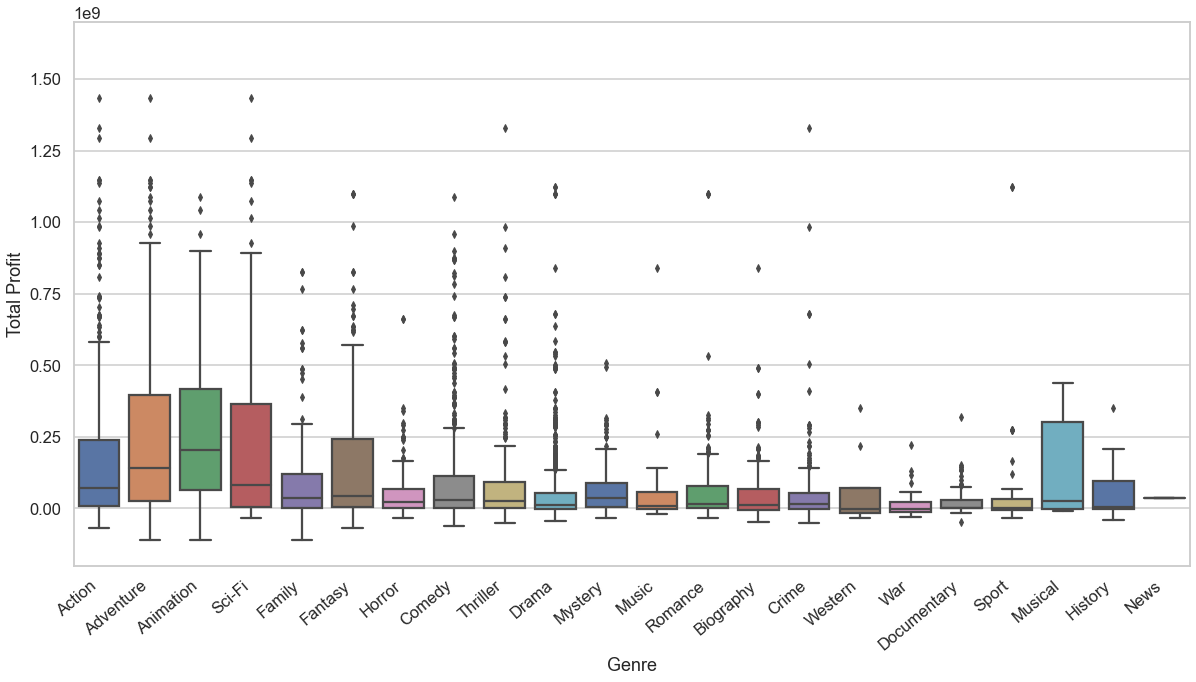

In [52]:
fig, ax = plt.subplots(figsize = (20,10))
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.4)

sns.boxplot(data = df_main, x = "genre", y = "worldwide_profit", palette = "deep").set(ylim = (-200000000, 1700000000), ylabel = "Total Profit", xlabel = "Genre")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");
# creating a broad boxplot looking at individual genres and total profit using seaborn. 



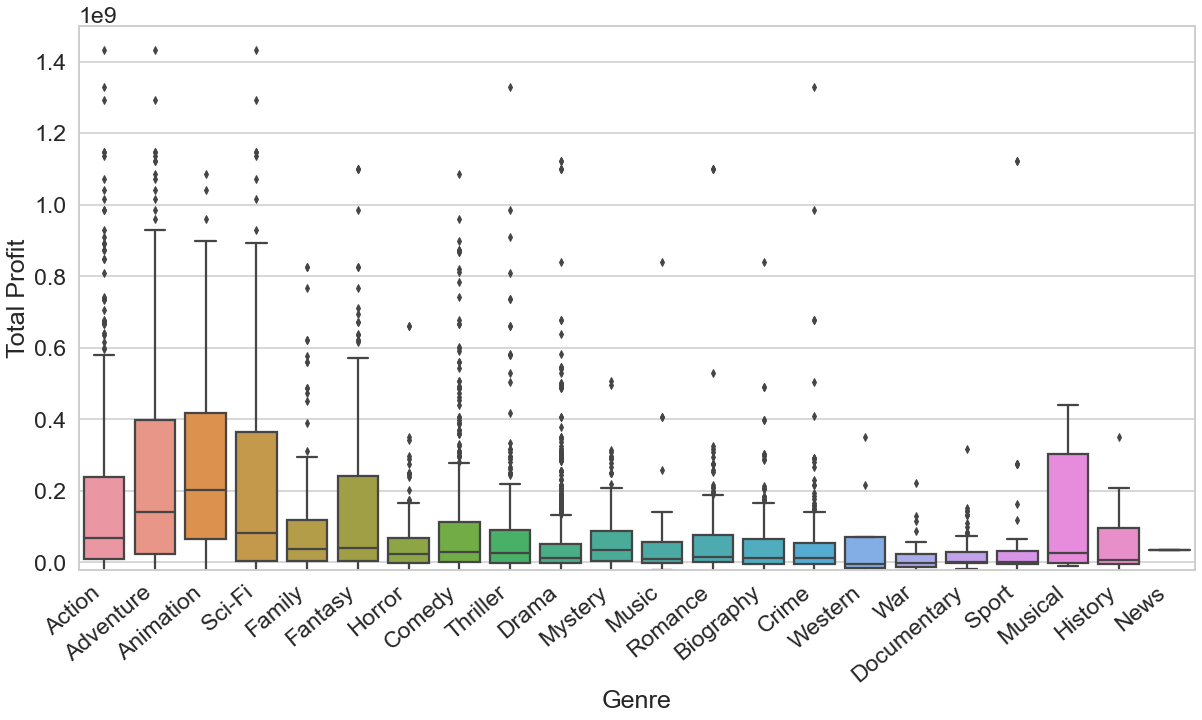

In [53]:
fig, ax = plt.subplots(figsize = (20,10))


sns.boxplot(data = df_main, x = "genre", y = "worldwide_profit").set(ylim = (-20000000, 1500000000), ylabel = "Total Profit", xlabel = "Genre")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

# playing with the y axis limit to find what looks best for the chart 

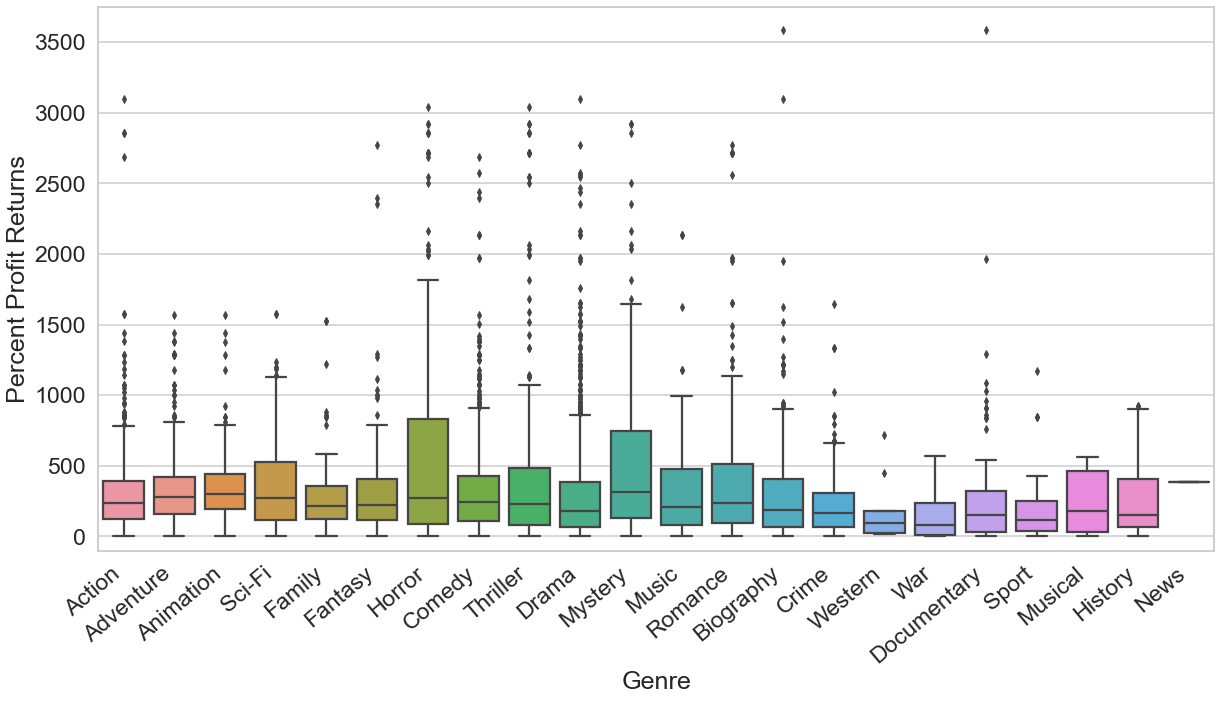

In [54]:
fig, ax = plt.subplots(figsize = (20,10))


sns.boxplot(data = df_main, x = "genre", y = "percent_returns").set(ylim = (-100, 3750), ylabel = "Percent Profit Returns", xlabel = "Genre")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

# creating a boxplot that examines the percent profit return by movie genre

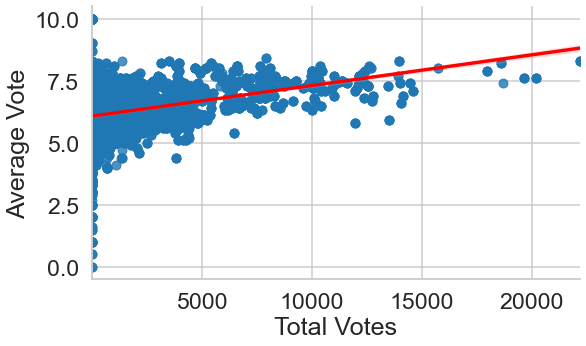

In [55]:
sns.lmplot(aspect=15/9, data = df_main, x = "vote_count", y = "vote_average", line_kws={'color': 'red'}).set(ylabel = "Average Vote", xlabel = "Total Votes");
# Here is a linear regression model comparing how the overall vote count impacts the average score of a movie.
# It effectively just confirms a positivity bias

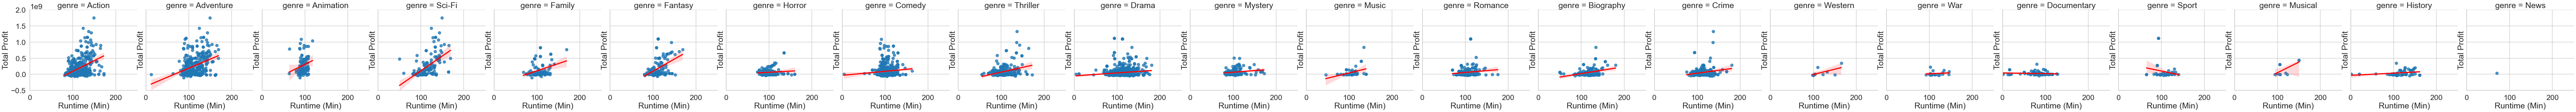

In [56]:
runtime = sns.lmplot(data = df_main, x = "runtime_minutes", y = "worldwide_profit", col = "genre", line_kws={'color': 'red'})
runtime.set(ylim = (-500000000, 2000000000), xlim = (0, 250), ylabel = "Total Profit", xlabel = "Runtime (Min)");
# These graphs were created as linear regression models of overall profit in relation to the length of the movie.
# Each individiual genre has its own linear regression model created for it.

## Making top 7 dataframes

In [57]:
df_mainmean.sort_values("percent_returns", ascending = False).head(7)
# We determined that as we are attempting to give suggestions for a successful movie not an unsuccessful one,
# we should only look at the top seven movies in both percent returns and worldwide profit categories

,genre,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns
13,Horror,10.013285,5.695928,1391.778281,8827.803167,98.583710,2.053599e+07,8.207340e+07,6.153741e+07,1088.129799
10,Mystery,12.474294,6.136364,2163.104895,14810.875524,106.468531,2.699386e+07,9.733352e+07,7.033965e+07,1023.680200
9,Thriller,11.254702,5.893168,1734.204969,11550.141925,104.605590,3.275625e+07,1.122991e+08,7.954280e+07,688.126177
8,Sport,7.775196,6.358696,925.043478,6511.928261,105.847826,2.530000e+07,1.096872e+08,8.438722e+07,644.462607
11,Romance,9.536311,6.456596,1376.519149,9378.966383,104.770213,2.303709e+07,8.547409e+07,6.243700e+07,507.634802
6,Family,11.563257,6.363810,1819.561905,12365.324762,102.847619,6.126190e+07,1.824633e+08,1.212014e+08,396.081206
19,News,4.738000,5.400000,21.000000,113.400000,70.000000,1.200000e+07,4.673058e+07,3.473058e+07,389.421483


In [58]:
df_mainmean.sort_values("worldwide_profit", ascending = False).head(7)

,genre,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns
0,Animation,15.311292,6.554717,2785.566038,19298.707547,95.169811,9.959434e+07,3.774225e+08,2.778281e+08,383.583839
1,Adventure,17.680828,6.374536,3976.984085,27198.927851,111.339523,1.052349e+08,3.592523e+08,2.540174e+08,334.731109
2,Sci-Fi,17.331122,6.331410,4589.583333,32000.405769,113.596154,8.645247e+07,3.223228e+08,2.358703e+08,367.619218
3,Action,16.688753,6.187773,3410.635371,22976.101528,112.849345,8.257904e+07,2.615523e+08,1.789733e+08,322.571959
4,Fantasy,15.602755,6.130216,3082.676259,20112.976978,110.410072,8.232482e+07,2.582219e+08,1.758970e+08,339.335712
5,Musical,10.608100,6.160000,1706.500000,12765.050000,115.600000,5.126000e+07,2.032923e+08,1.520323e+08,250.854039
6,Family,11.563257,6.363810,1819.561905,12365.324762,102.847619,6.126190e+07,1.824633e+08,1.212014e+08,396.081206


In [59]:
df_main.head()
# A quick sanity check to clear my head and refocus on what needed to be done

,popularity,title,vote_average,vote_count,vote_total,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns
0,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Action,165000000,494870992,329870992,2010-03-26,299.921813
1,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Adventure,165000000,494870992,329870992,2010-03-26,299.921813
2,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Animation,165000000,494870992,329870992,2010-03-26,299.921813
3,28.515,Iron Man 2,6.8,12368,84102.4,124.0,Action,170000000,621156389,451156389,2010-05-07,365.386111
4,28.515,Iron Man 2,6.8,12368,84102.4,124.0,Adventure,170000000,621156389,451156389,2010-05-07,365.386111


In [60]:
df_main.to_csv("Prebuilt_stuff\data\main_data_compilation.csv")
# exported my primary data table into a csv file for the rest of my team to have easy access to

In [61]:
df_main.to_sql("main_table", conn)
# I wanted to create two subdataframes and with the qualifications I wanted it was going to be easiest to complete in SQL.
# So I forced the dataframe into SQL

In [62]:
df_top7_profit_returns = pd.read_sql("""
SELECT *
FROM main_table
WHERE genre = 'Thriller' OR genre = 'Sport' OR genre = 'Mystery' OR genre = 'News' OR genre = 'Horror' OR genre = 'Family' OR genre = 'Romance'
""", conn)
# Using SQL I created a table including only the top seven genres with the greatest returns per dollar spent on the movie

In [63]:
df_top7_worldwide_profit = pd.read_sql("""
SELECT *
FROM main_table
WHERE genre = 'Musical' OR genre = 'Adventure' OR genre = 'Fantasy' OR genre = 'Animation' OR genre = 'Sci-Fi' OR genre = 'Family' OR genre = 'Action'
""", conn)
# Using SQL I created a table only including the top seven genres in terms of total profit generated

### Making top 7 graphs

Now that we have the top seven dataframe's and the overall idea's for what visuals worked well we can make some more clear, easy to read visuals

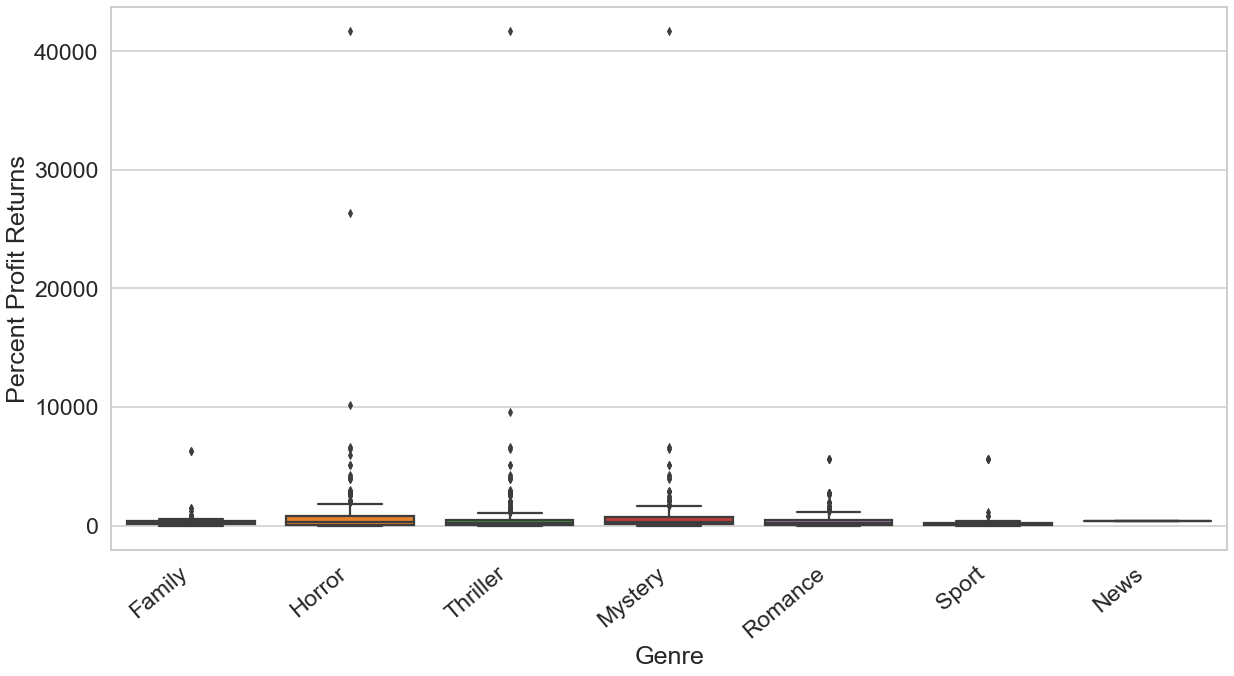

In [64]:
fig, ax = plt.subplots(figsize = (20,10))

sns.boxplot(data = df_top7_profit_returns, x = "genre", y = "percent_returns").set(ylabel = "Percent Profit Returns", xlabel = "Genre")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

# plt.savefig('Fun_Horror_visual_we_dont_actually_need.png', dpi=300)
# Created a boxplot showing percent returns by the top seven genres

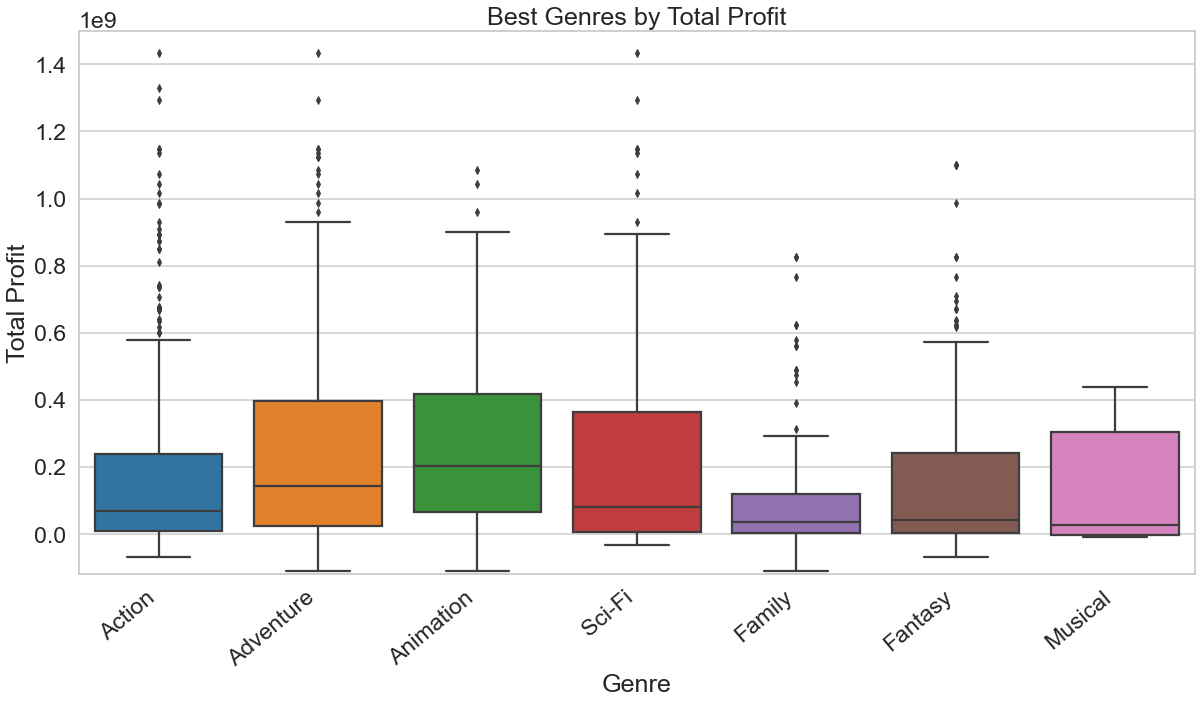

In [65]:
fig, ax = plt.subplots(figsize = (20,10))

sns.boxplot(data = df_top7_worldwide_profit, x = "genre", y = "worldwide_profit").set(ylim = (-120000000, 1500000000), ylabel = "Total Profit", xlabel = "Genre", title = "Best Genres by Total Profit")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

# plt.savefig('Best_Genres_by_Total_Profit.png', dpi=300)
# Created a boxplot showing the total profit by the top seven genres in that category

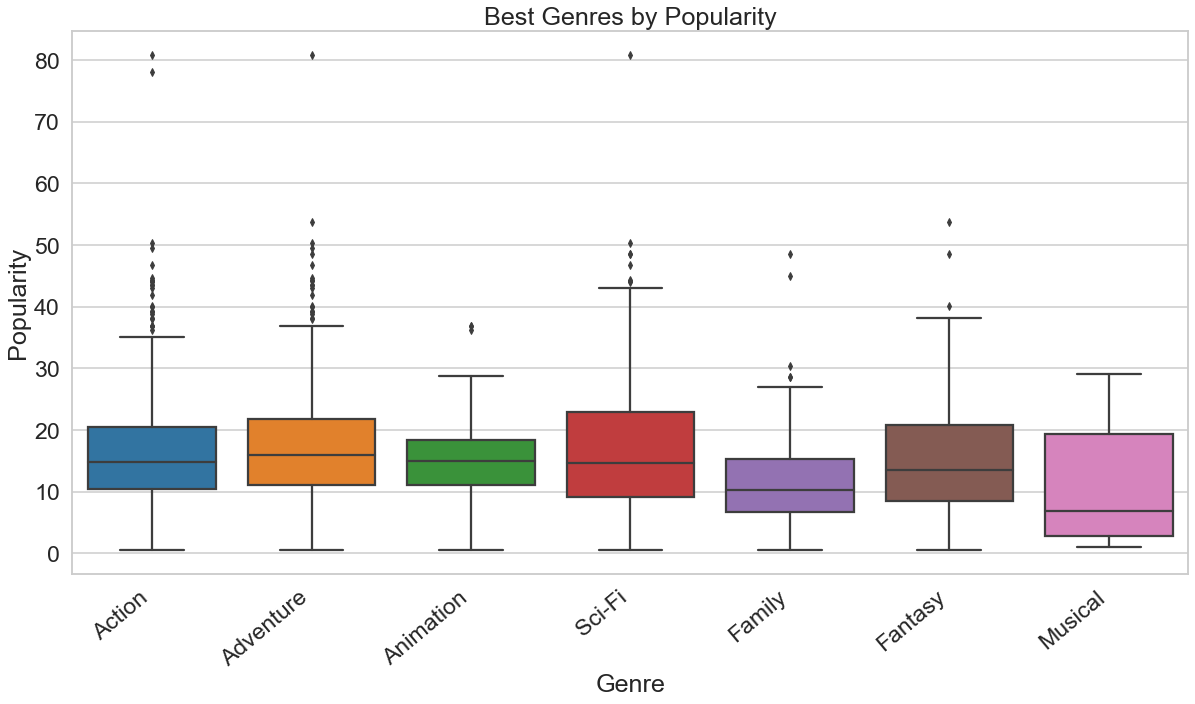

In [66]:
fig, ax = plt.subplots(figsize = (20,10))

sns.boxplot(data = df_top7_worldwide_profit, x = "genre", y = "popularity").set(ylabel = "Popularity", xlabel = "Genre", title = "Best Genres by Popularity")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

# plt.savefig('Best_Genres_by_Popularity.png', dpi=300)


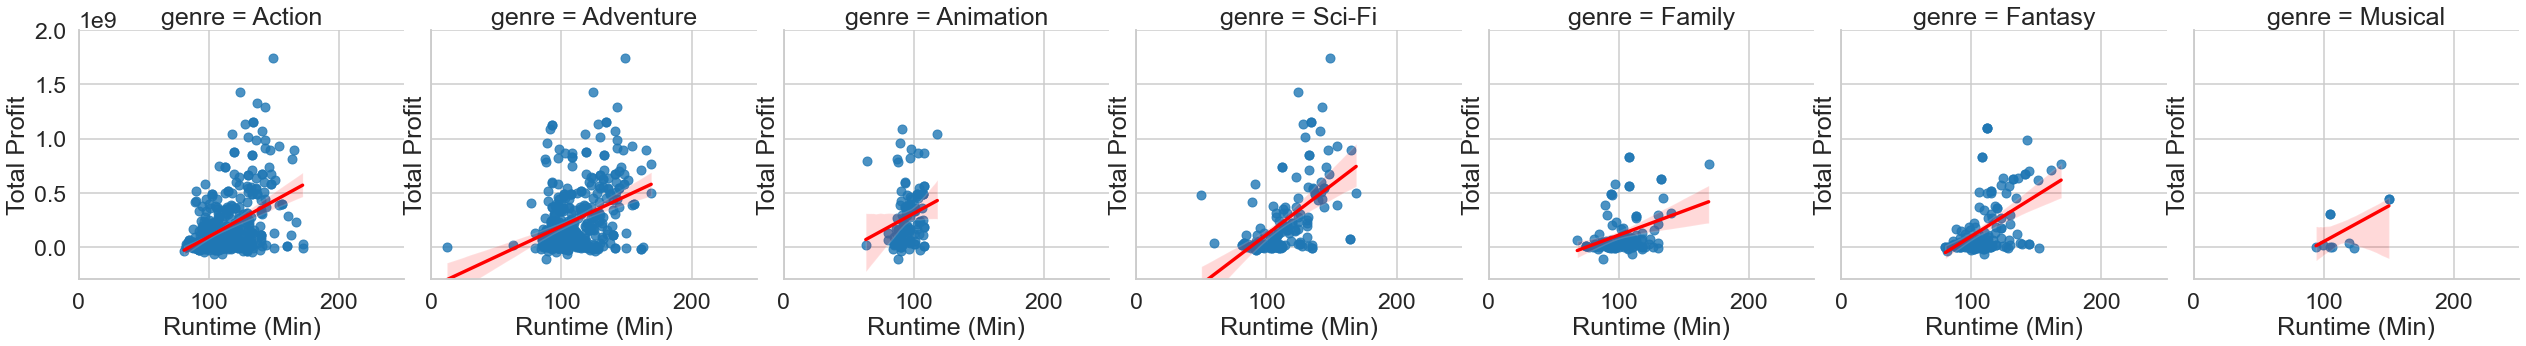

In [67]:
runtime = sns.lmplot(data = df_top7_worldwide_profit, x = "runtime_minutes", y = "worldwide_profit", col = "genre", line_kws={'color': 'red'})
runtime.set(ylim = (-300000000, 2000000000), xlim = (0, 250), ylabel = "Total Profit", xlabel = "Runtime (Min)");

# plt.savefig('Genres_by_runtime.png', dpi=300)
# These graphs were created as linear regression models of overall profit in relation to the length of the movie.
# Each individiual genre has its own linear regression model created for it.

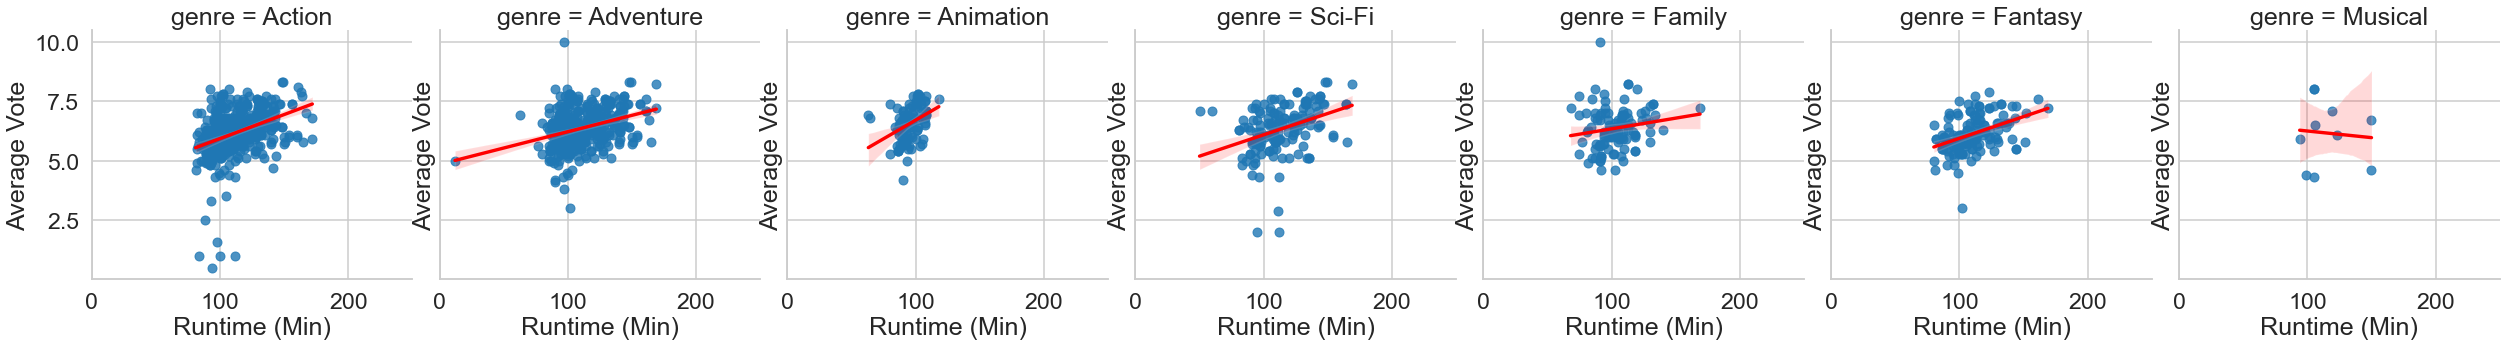

In [68]:
runtime = sns.lmplot(data = df_top7_worldwide_profit, x = "runtime_minutes", y = "vote_average", col = "genre", line_kws={'color': 'red'})
runtime.set(xlim = (0, 250), ylabel = "Average Vote", xlabel = "Runtime (Min)");

# plt.savefig('Genres_by_runtime_and_average_vote.png', dpi=300)
# These graphs were created as linear regression models of average rating to the length of the movie.
# Each individiual genre has its own linear regression model created for it.

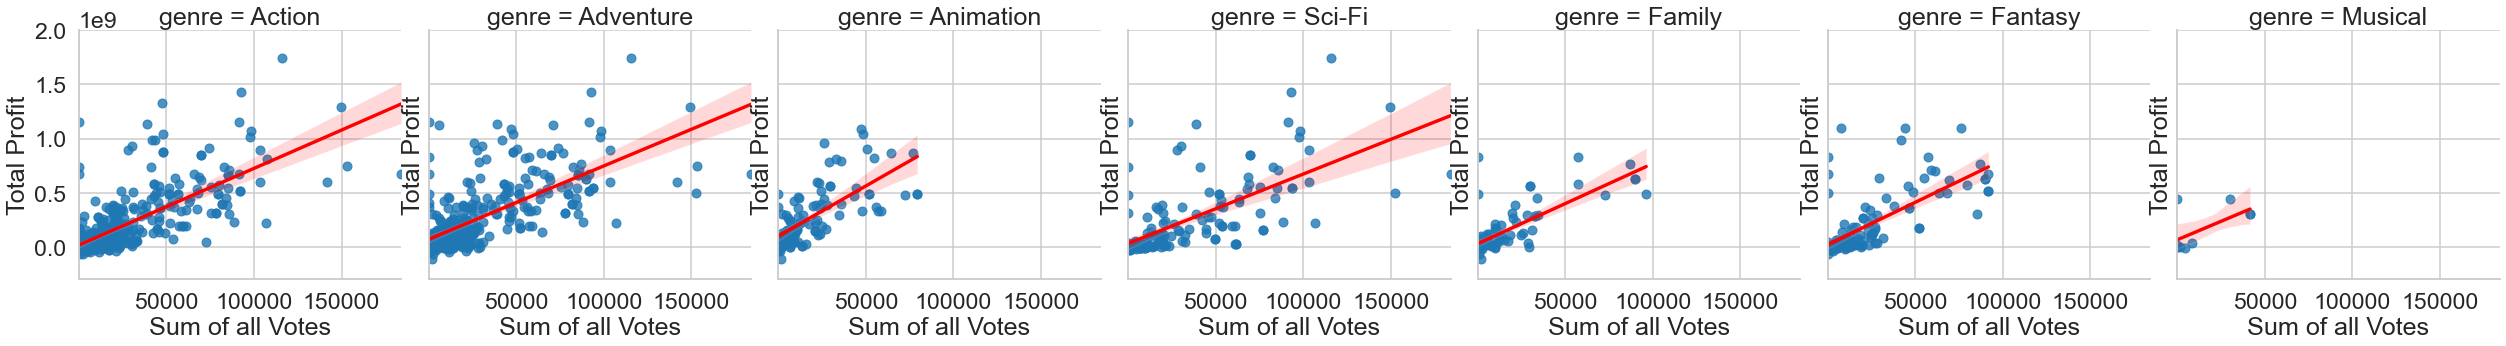

In [69]:
runtime = sns.lmplot(data = df_top7_worldwide_profit, x = "vote_total", y = "worldwide_profit", col = "genre", line_kws={'color': 'red'})
runtime.set(ylim = (-300000000, 2000000000), ylabel = "Total Profit", xlabel = "Sum of all Votes");
# These graphs were created as linear regression models of overall profit in relation to the total numbers of upvotes the movie was given.
# Each individiual genre has its own linear regression model created for it.

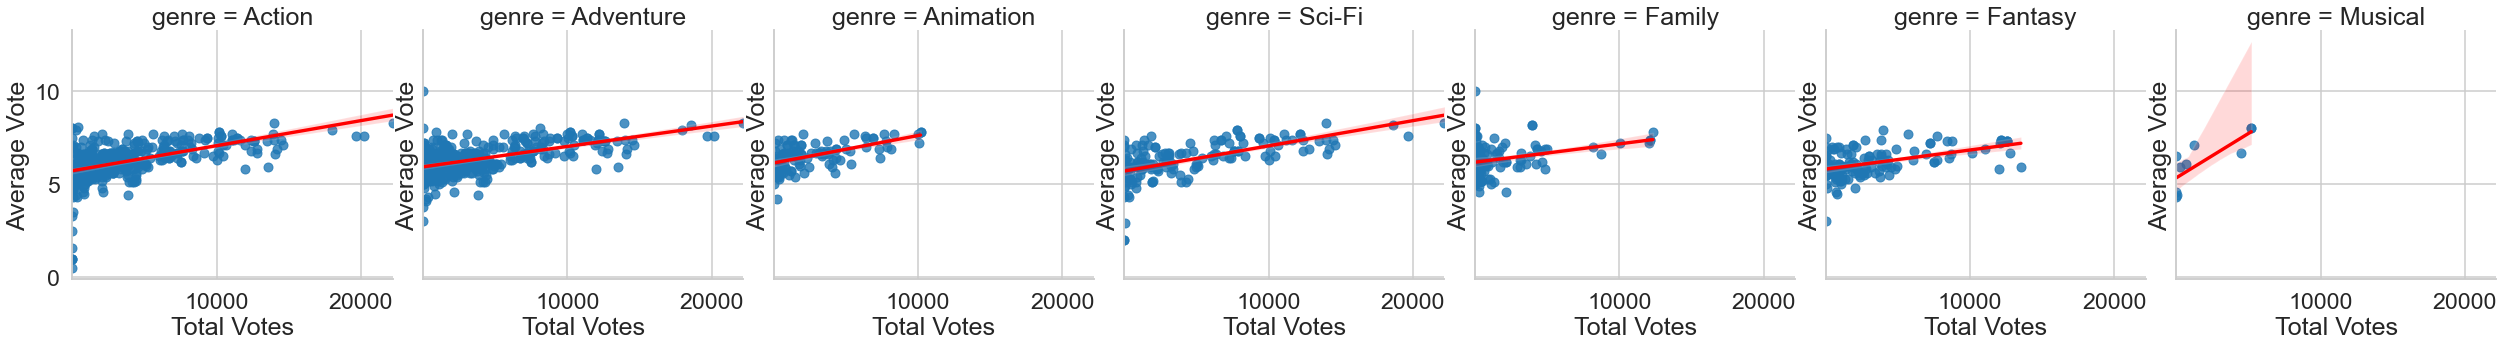

In [70]:
runtime = sns.lmplot(data = df_top7_worldwide_profit, x = "vote_count", y = "vote_average", col = "genre", line_kws={'color': 'red'})
runtime.set(ylabel = "Average Vote", xlabel = "Total Votes");

# plt.savefig('Genres_by_voting_nonsense.png', dpi=300)
# These graphs were created as linear regression models of the average vote in relation to the total numbers of votes the movie was given.
# Each individiual genre has its own linear regression model created for it.

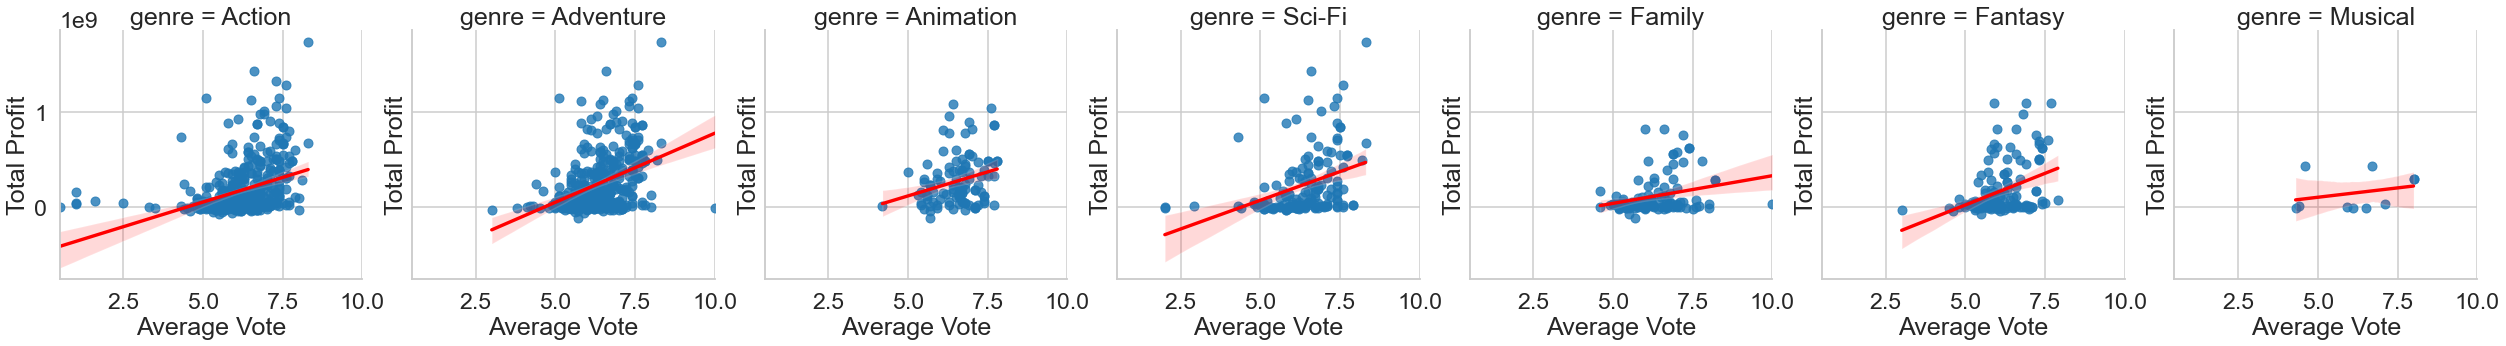

In [71]:
runtime = sns.lmplot(data = df_top7_worldwide_profit, x = "vote_average", y = "worldwide_profit", col = "genre", line_kws={'color': 'red'})
runtime.set(ylabel = "Total Profit", xlabel = "Average Vote");

# plt.savefig('Proof_average_vote_indicative_of_increased_profit.png', dpi=300)
# These graphs were created as linear regression models of the average vote in relation to the total numbers of votes the movie was given.
# Each individiual genre has its own linear regression model created for it.

In [72]:
df_main.groupby("genre").median().sort_values("worldwide_profit", ascending = False)
# median values

,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns
genre,,,,,,,,,
Animation,14.9535,6.60,1780.5,11367.65,95.0,87500000.0,327829122.5,202467009.0,299.854564
Adventure,15.9740,6.30,2494.0,15623.30,107.0,99000000.0,252276928.0,141751370.0,278.548520
Sci-Fi,14.6880,6.40,2898.0,18207.00,110.5,60500000.0,157526241.0,81982857.0,271.315763
Action,14.8850,6.20,2182.0,13143.20,110.0,60000000.0,135965960.0,69694743.0,239.910873
Fantasy,13.4670,6.00,1884.0,11115.60,109.0,50000000.0,91678442.0,41647574.0,222.991235
Family,10.2080,6.30,492.0,3393.80,102.0,35000000.0,76954311.0,37293371.0,213.142587
Mystery,10.8410,6.20,1098.0,6623.60,104.0,12500000.0,54104225.0,35308153.0,318.109630
News,4.7380,5.40,21.0,113.40,70.0,12000000.0,46730578.0,34730578.0,389.421483
Comedy,10.2850,6.20,814.5,4906.80,101.0,24000000.0,60376812.5,29817257.5,244.057020


In [73]:
df_main.groupby("genre").std().sort_values("worldwide_profit", ascending = False)
# standard deviation values

,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns
genre,,,,,,,,,
Sci-Fi,12.356796,1.013955,4675.933535,35432.670882,20.601215,7.928861e+07,3.979697e+08,3.368228e+08,324.133479
Adventure,10.314864,0.817292,4114.982190,30733.315553,19.561859,7.387076e+07,3.509658e+08,3.018691e+08,265.200600
Fantasy,10.091369,0.750039,3454.311977,24041.662434,17.281058,8.006270e+07,3.276507e+08,2.693866e+08,417.901237
Action,10.259079,0.963254,3733.533048,27529.579582,17.909608,7.027044e+07,3.172053e+08,2.666629e+08,353.909497
Animation,6.715705,0.702801,2669.633669,19818.380073,8.579568,5.522789e+07,2.950703e+08,2.643117e+08,294.826046
Sport,6.884921,0.902238,2119.846063,15397.831949,17.158046,3.344526e+07,2.639669e+08,2.382381e+08,1557.455911
Family,8.677706,0.888508,2837.104754,20602.355782,16.309967,6.225794e+07,2.438258e+08,1.990399e+08,873.410407
Musical,10.202152,1.379372,2291.323987,17747.977914,20.012218,3.979180e+07,2.286713e+08,1.944202e+08,235.478836
Horror,6.011405,1.080712,2061.179607,14651.409073,14.881914,3.822154e+07,2.079199e+08,1.786043e+08,3500.779366


In [74]:
df_main.groupby("genre").mean().sort_values("worldwide_profit", ascending = False)

,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns
genre,,,,,,,,,
Animation,15.311292,6.554717,2785.566038,19298.707547,95.169811,9.959434e+07,3.774225e+08,2.778281e+08,383.583839
Adventure,17.680828,6.374536,3976.984085,27198.927851,111.339523,1.052349e+08,3.592523e+08,2.540174e+08,334.731109
Sci-Fi,17.331122,6.331410,4589.583333,32000.405769,113.596154,8.645247e+07,3.223228e+08,2.358703e+08,367.619218
Action,16.688753,6.187773,3410.635371,22976.101528,112.849345,8.257904e+07,2.615523e+08,1.789733e+08,322.571959
Fantasy,15.602755,6.130216,3082.676259,20112.976978,110.410072,8.232482e+07,2.582219e+08,1.758970e+08,339.335712
Musical,10.608100,6.160000,1706.500000,12765.050000,115.600000,5.126000e+07,2.032923e+08,1.520323e+08,250.854039
Family,11.563257,6.363810,1819.561905,12365.324762,102.847619,6.126190e+07,1.824633e+08,1.212014e+08,396.081206
Comedy,11.379656,6.270415,1633.726644,10978.081315,101.719723,3.883083e+07,1.331579e+08,9.432706e+07,376.500128
Sport,7.775196,6.358696,925.043478,6511.928261,105.847826,2.530000e+07,1.096872e+08,8.438722e+07,644.462607


<hr><font color="green"><h1>Director Data by Helen Abele</h1></font>

First, I took the IMBD Title Principal Data and dropped the unecessary values.

In [75]:
title_principals = pd.read_csv('data/zippedData/imdb.title.principals.csv.gz')
title_principals.head()

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


In [76]:
title_pricipals_1 = title_principals.drop('job', axis=1)
title_pricipals_1.head()

,tconst,ordering,nconst,category,characters
0,tt0111414,1,nm0246005,actor,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN
2,tt0111414,3,nm3739909,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN
4,tt0323808,1,nm3579312,actress,"[""Beth Boothby""]"


In [77]:
main_pricipals = title_pricipals_1.drop('characters', axis=1)
main_pricipals.head()

,tconst,ordering,nconst,category
0,tt0111414,1,nm0246005,actor
1,tt0111414,2,nm0398271,director
2,tt0111414,3,nm3739909,producer
3,tt0323808,10,nm0059247,editor
4,tt0323808,1,nm3579312,actress


I did then the same with the IMBD Basics Title data

In [78]:
title_basics = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
title_basics.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [79]:
title_basics_1 = title_basics.drop('original_title', axis=1)
title_basics_1.head()

,tconst,primary_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy"


In [80]:
title_basics_2 = title_basics_1.drop('start_year', axis=1)
title_basics_2.head()

,tconst,primary_title,runtime_minutes,genres
0,tt0063540,Sunghursh,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,122.0,Drama
3,tt0069204,Sabse Bada Sukh,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy"


In [81]:
main_titles = title_basics_2.drop('runtime_minutes', axis=1)
main_titles.head()

,tconst,primary_title,genres
0,tt0063540,Sunghursh,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,Drama
3,tt0069204,Sabse Bada Sukh,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,"Comedy,Drama,Fantasy"


I then merged the two dataframes 

In [82]:
director = main_titles.merge(main_pricipals, on="tconst", how='inner')
director.head()

,tconst,primary_title,genres,ordering,nconst,category
0,tt0063540,Sunghursh,"Action,Crime,Drama",10,nm0006210,composer
1,tt0063540,Sunghursh,"Action,Crime,Drama",1,nm0474801,actor
2,tt0063540,Sunghursh,"Action,Crime,Drama",2,nm0904537,actress
3,tt0063540,Sunghursh,"Action,Crime,Drama",3,nm0756379,actor
4,tt0063540,Sunghursh,"Action,Crime,Drama",4,nm0474876,actor


After the merge, I then took out all rows in the category column that is not director.

In [83]:
categories = director[director['category'] == 'director']
# director.drop(categories, inplace=False)
categories.head()

,tconst,primary_title,genres,ordering,nconst,category
5,tt0063540,Sunghursh,"Action,Crime,Drama",5,nm0712540,director
14,tt0066787,One Day Before the Rainy Season,"Biography,Drama",5,nm0002411,director
22,tt0069049,The Other Side of the Wind,Drama,5,nm0000080,director
32,tt0069204,Sabse Bada Sukh,"Comedy,Drama",5,nm0611531,director
42,tt0100275,The Wandering Soap Opera,"Comedy,Drama,Fantasy",5,nm0749914,director


I then split the lists in the genres column using the lambda function

In [84]:
categories["genres"] = categories["genres"].apply(lambda x: x.split(",") if type(x) == str else x)
categories["genres"].head()

<ipython-input-84-6f53b0115607>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categories["genres"] = categories["genres"].apply(lambda x: x.split(",") if type(x) == str else x)


5       [Action, Crime, Drama]
14          [Biography, Drama]
22                     [Drama]
32             [Comedy, Drama]
42    [Comedy, Drama, Fantasy]
Name: genres, dtype: object

Next, I used .explode in order to make a row for in genre of the specific movie

In [85]:
categories_1 = (categories.explode('genres'))
categories_1.head()

,tconst,primary_title,genres,ordering,nconst,category
5,tt0063540,Sunghursh,Action,5,nm0712540,director
5,tt0063540,Sunghursh,Crime,5,nm0712540,director
5,tt0063540,Sunghursh,Drama,5,nm0712540,director
14,tt0066787,One Day Before the Rainy Season,Biography,5,nm0002411,director
14,tt0066787,One Day Before the Rainy Season,Drama,5,nm0002411,director


I then dropped all values in the genre column that were not adventure

In [86]:
genres = categories_1[categories_1['genres'] == 'Adventure']
# director.drop(genres, inplace=False)
genres.head()

,tconst,primary_title,genres,ordering,nconst,category
255,tt0293429,Mortal Kombat,Adventure,1,nm2585406,director
282,tt0312305,Quantum Quest: A Cassini Space Odyssey,Adventure,5,nm1004541,director
283,tt0312305,Quantum Quest: A Cassini Space Odyssey,Adventure,6,nm0820800,director
342,tt0329539,Rice Girl,Adventure,5,nm0278780,director
368,tt0331314,Bunyan and Babe,Adventure,5,nm8625898,director


Next, I opened the IMBD Name Basics Data

In [87]:
name_basics = pd.read_csv('data/zippedData/imdb.name.basics.csv.gz')
name_basics.head()

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


I then cleaned the dataframe

In [88]:
name_basics_1 = name_basics.drop('birth_year', axis=1)
name_basics_1.head()

,nconst,primary_name,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [89]:
name_basics_2 = name_basics_1.drop('death_year', axis=1)
name_basics_2.head()

,nconst,primary_name,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [90]:
name_basics_3 = name_basics_2.drop('known_for_titles', axis=1)
name_basics_3.head()

,nconst,primary_name,primary_profession
0,nm0061671,Mary Ellen Bauder,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,"production_designer,art_department,set_decorator"


Once again, I used the Lambda function to seperate the lists in the primary profession column

In [91]:
name_basics_3["primary_profession"] = name_basics_3["primary_profession"].apply(lambda x: x.split(",") if type(x) == str else x)
name_basics_3["primary_profession"].head()

0        [miscellaneous, production_manager, producer]
1       [composer, music_department, sound_department]
2                       [miscellaneous, actor, writer]
3    [camera_department, cinematographer, art_depar...
4    [production_designer, art_department, set_deco...
Name: primary_profession, dtype: object

I then used .explode in order to make a row for in genre of the specific movie

In [92]:
name_basics_4 = (name_basics_3.explode('primary_profession'))
name_basics_4.head()

,nconst,primary_name,primary_profession
0,nm0061671,Mary Ellen Bauder,miscellaneous
0,nm0061671,Mary Ellen Bauder,production_manager
0,nm0061671,Mary Ellen Bauder,producer
1,nm0061865,Joseph Bauer,composer
1,nm0061865,Joseph Bauer,music_department


I then dropped all the values in the primary_profession that were not director

In [93]:
final_name = name_basics_4[name_basics_4['primary_profession'] == 'director']
final_name.head()

,nconst,primary_name,primary_profession
5,nm0062879,Ruel S. Bayani,director
10,nm0064023,Bryan Beasley,director
15,nm0066163,Arnaud Bedouët,director
16,nm0066268,Steve Mitchell Beebe,director
21,nm0068170,Dylan Bell,director


I then merged the Name Basics Dataframe with the datafram that was already merged

In [94]:
director_merge = genres.merge(final_name, on="nconst", how='inner')
director_merge.head()

,tconst,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,tt0293429,Mortal Kombat,Adventure,1,nm2585406,director,Simon McQuoid,director
1,tt0312305,Quantum Quest: A Cassini Space Odyssey,Adventure,6,nm0820800,director,Daniel St. Pierre,director
2,tt0884726,Legends of Oz: Dorothy's Return,Adventure,6,nm0820800,director,Daniel St. Pierre,director
3,tt0329539,Rice Girl,Adventure,5,nm0278780,director,Michael Fischa,director
4,tt0331314,Bunyan and Babe,Adventure,5,nm8625898,director,Louis Ross,director


I then found the five directors that have directed the most adventure movies

In [95]:
top_five = director_merge.primary_name.value_counts().head()
top_five

Kôbun Shizuno      9
Kunihiko Yuyama    8
David Yates        8
Mark Polonia       6
Hark Tsui          6
Name: primary_name, dtype: int64

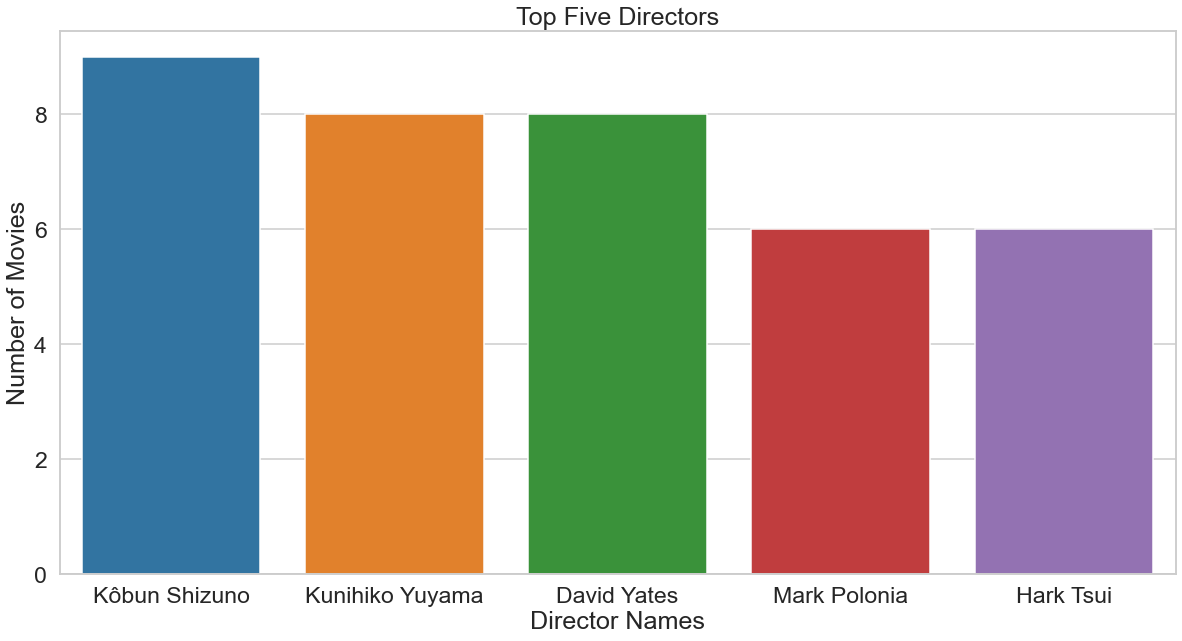

In [96]:
fig, ax = plt.subplots(figsize = (20,10))
top_five_graph = sns.barplot(x=top_five.index, y=top_five.values)
top_five_graph.set(title="Top Five Directors", xlabel="Director Names", ylabel="Number of Movies");
# plt.savefig('Top Five Directors with Most Adventure Movies.png', dpi=300)

I then wanted to find out which director has made the top grossing adventure movie worldwide. 
I started by taking Jerry's data that he compiled and cleaned

In [97]:
budget_main = pd.read_csv("data/main_data_compilation.csv")

In [98]:
budget_main.drop(columns='Unnamed: 0', inplace=True)
budget_main

,popularity,title,vote_average,vote_count,vote_total,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns
0,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Action,165000000,494870992,329870992,2010-03-26,299.921813
1,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Adventure,165000000,494870992,329870992,2010-03-26,299.921813
2,28.734,How to Train Your Dragon,7.7,7610,58597.0,98.0,Animation,165000000,494870992,329870992,2010-03-26,299.921813
3,28.515,Iron Man 2,6.8,12368,84102.4,124.0,Action,170000000,621156389,451156389,2010-05-07,365.386111
4,28.515,Iron Man 2,6.8,12368,84102.4,124.0,Adventure,170000000,621156389,451156389,2010-05-07,365.386111
...,...,...,...,...,...,...,...,...,...,...,...,...
7535,0.600,The Box,6.0,1,6.0,100.0,Drama,25000000,34356760,9356760,2018-03-04,137.427040
7536,0.600,The Box,6.0,1,6.0,100.0,War,25000000,34356760,9356760,2018-03-04,137.427040
7537,0.600,The Box,6.0,1,6.0,56.0,Thriller,25000000,34356760,9356760,2018-03-04,137.427040
7538,0.719,Enough,8.7,3,26.1,96.0,Drama,38000000,50970660,12970660,2018-03-22,134.133316


Josh then cleaned and did some more merging with Jerry's dataframe

In [99]:
budget_main["title"] = budget_main["title"].str.lower().str.replace('[^a-zA-Z0-9]', '_').copy()
clean_budget_main = budget_main.drop_duplicates("title")

<ipython-input-99-3e796650a9f1>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  budget_main["title"] = budget_main["title"].str.lower().str.replace('[^a-zA-Z0-9]', '_').copy()


In [100]:
director_merge['title']=director_merge['primary_title']

In [101]:
director_merge.drop(columns=["primary_title","tconst","nconst"])

,genres,ordering,category,primary_name,primary_profession,title
0,Adventure,1,director,Simon McQuoid,director,Mortal Kombat
1,Adventure,6,director,Daniel St. Pierre,director,Quantum Quest: A Cassini Space Odyssey
2,Adventure,6,director,Daniel St. Pierre,director,Legends of Oz: Dorothy's Return
3,Adventure,5,director,Michael Fischa,director,Rice Girl
4,Adventure,5,director,Louis Ross,director,Bunyan and Babe
...,...,...,...,...,...,...
5914,Adventure,5,director,Dong-Seok Noh,director,Pokemon XY
5915,Adventure,5,director,Robert Fernandez,director,The Pilgrim's Progress
5916,Adventure,4,director,Li Yadong,director,River Pirates
5917,Adventure,1,director,Aleks Alifirenko Jr.,director,The Robinsons


In [102]:
director_merge["title"] = director_merge["title"].str.lower().str.replace('[^a-zA-Z0-9]', '_').copy()
clean_director_merge = director_merge.drop_duplicates("title")

<ipython-input-102-73eca96d2dd8>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  director_merge["title"] = director_merge["title"].str.lower().str.replace('[^a-zA-Z0-9]', '_').copy()


In [103]:
workable_df = clean_budget_main.merge(clean_director_merge, on=["title"], how="inner").copy()

In [104]:
workable_df

,popularity,title,vote_average,vote_count,vote_total,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns,tconst,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,28.734,how_to_train_your_dragon,7.7,7610,58597.0,98.0,Action,165000000,494870992,329870992,2010-03-26,299.921813,tt0892769,How to Train Your Dragon,Adventure,5,nm0213450,director,Dean DeBlois,director
1,27.920,inception,8.3,22186,184143.8,148.0,Action,160000000,835524642,675524642,2010-07-16,522.202901,tt1375666,Inception,Adventure,5,nm0634240,director,Christopher Nolan,director
2,26.691,percy_jackson___the_olympians__the_lightning_t...,6.1,4229,25796.9,118.0,Adventure,95000000,223050874,128050874,2010-02-11,234.790394,tt0814255,Percy Jackson & the Olympians: The Lightning T...,Adventure,5,nm0001060,director,Chris Columbus,director
3,22.020,alice_in_wonderland,6.6,8713,57505.8,108.0,Adventure,200000000,1025491110,825491110,2010-03-05,512.745555,tt1014759,Alice in Wonderland,Adventure,5,nm0000318,director,Tim Burton,director
4,21.511,tangled,7.5,6407,48052.5,100.0,Adventure,260000000,586477240,326477240,2010-11-24,225.568169,tt0398286,Tangled,Adventure,5,nm1977355,director,Nathan Greno,director
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,12.987,sherlock_gnomes,5.4,343,1852.2,86.0,Adventure,59000000,87527651,28527651,2018-03-23,148.351951,tt2296777,Sherlock Gnomes,Adventure,5,nm0828970,director,John Stevenson,director
323,12.005,paul__apostle_of_christ,7.1,98,695.8,108.0,Adventure,5000000,25529498,20529498,2018-03-28,510.589960,tt7388562,"Paul, Apostle of Christ",Adventure,5,nm1358366,director,Andrew Hyatt,director
324,6.868,dragon_ball_super__broly,7.4,721,5335.4,100.0,Action,8500000,122747755,114247755,2019-01-16,1444.091235,tt7961060,Dragon Ball Super: Broly,Adventure,5,nm0619110,director,Tatsuya Nagamine,director
325,6.107,sgt__stubby__an_american_hero,6.4,9,57.6,84.0,Adventure,25000000,3645957,-21354043,2018-04-13,14.583828,tt5314190,Sgt. Stubby: An American Hero,Adventure,5,nm4175844,director,Richard Lanni,director


Once the dataframe was turned back over to me I then dropped many of the columns that I did not need

In [105]:
workable_1 = workable_df.drop('popularity', axis=1)
workable_1.head()

,title,vote_average,vote_count,vote_total,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns,tconst,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,how_to_train_your_dragon,7.7,7610,58597.0,98.0,Action,165000000,494870992,329870992,2010-03-26,299.921813,tt0892769,How to Train Your Dragon,Adventure,5,nm0213450,director,Dean DeBlois,director
1,inception,8.3,22186,184143.8,148.0,Action,160000000,835524642,675524642,2010-07-16,522.202901,tt1375666,Inception,Adventure,5,nm0634240,director,Christopher Nolan,director
2,percy_jackson___the_olympians__the_lightning_t...,6.1,4229,25796.9,118.0,Adventure,95000000,223050874,128050874,2010-02-11,234.790394,tt0814255,Percy Jackson & the Olympians: The Lightning T...,Adventure,5,nm0001060,director,Chris Columbus,director
3,alice_in_wonderland,6.6,8713,57505.8,108.0,Adventure,200000000,1025491110,825491110,2010-03-05,512.745555,tt1014759,Alice in Wonderland,Adventure,5,nm0000318,director,Tim Burton,director
4,tangled,7.5,6407,48052.5,100.0,Adventure,260000000,586477240,326477240,2010-11-24,225.568169,tt0398286,Tangled,Adventure,5,nm1977355,director,Nathan Greno,director


In [106]:
workable_2 = workable_1.drop('vote_average', axis=1)
workable_2.head()

,title,vote_count,vote_total,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns,tconst,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,how_to_train_your_dragon,7610,58597.0,98.0,Action,165000000,494870992,329870992,2010-03-26,299.921813,tt0892769,How to Train Your Dragon,Adventure,5,nm0213450,director,Dean DeBlois,director
1,inception,22186,184143.8,148.0,Action,160000000,835524642,675524642,2010-07-16,522.202901,tt1375666,Inception,Adventure,5,nm0634240,director,Christopher Nolan,director
2,percy_jackson___the_olympians__the_lightning_t...,4229,25796.9,118.0,Adventure,95000000,223050874,128050874,2010-02-11,234.790394,tt0814255,Percy Jackson & the Olympians: The Lightning T...,Adventure,5,nm0001060,director,Chris Columbus,director
3,alice_in_wonderland,8713,57505.8,108.0,Adventure,200000000,1025491110,825491110,2010-03-05,512.745555,tt1014759,Alice in Wonderland,Adventure,5,nm0000318,director,Tim Burton,director
4,tangled,6407,48052.5,100.0,Adventure,260000000,586477240,326477240,2010-11-24,225.568169,tt0398286,Tangled,Adventure,5,nm1977355,director,Nathan Greno,director


In [107]:
workable_3 = workable_2.drop('vote_count', axis=1)
workable_3.head()

,title,vote_total,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns,tconst,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,how_to_train_your_dragon,58597.0,98.0,Action,165000000,494870992,329870992,2010-03-26,299.921813,tt0892769,How to Train Your Dragon,Adventure,5,nm0213450,director,Dean DeBlois,director
1,inception,184143.8,148.0,Action,160000000,835524642,675524642,2010-07-16,522.202901,tt1375666,Inception,Adventure,5,nm0634240,director,Christopher Nolan,director
2,percy_jackson___the_olympians__the_lightning_t...,25796.9,118.0,Adventure,95000000,223050874,128050874,2010-02-11,234.790394,tt0814255,Percy Jackson & the Olympians: The Lightning T...,Adventure,5,nm0001060,director,Chris Columbus,director
3,alice_in_wonderland,57505.8,108.0,Adventure,200000000,1025491110,825491110,2010-03-05,512.745555,tt1014759,Alice in Wonderland,Adventure,5,nm0000318,director,Tim Burton,director
4,tangled,48052.5,100.0,Adventure,260000000,586477240,326477240,2010-11-24,225.568169,tt0398286,Tangled,Adventure,5,nm1977355,director,Nathan Greno,director


In [108]:
workable_4 = workable_3.drop('vote_total', axis=1)
workable_4.head()

,title,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns,tconst,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,how_to_train_your_dragon,98.0,Action,165000000,494870992,329870992,2010-03-26,299.921813,tt0892769,How to Train Your Dragon,Adventure,5,nm0213450,director,Dean DeBlois,director
1,inception,148.0,Action,160000000,835524642,675524642,2010-07-16,522.202901,tt1375666,Inception,Adventure,5,nm0634240,director,Christopher Nolan,director
2,percy_jackson___the_olympians__the_lightning_t...,118.0,Adventure,95000000,223050874,128050874,2010-02-11,234.790394,tt0814255,Percy Jackson & the Olympians: The Lightning T...,Adventure,5,nm0001060,director,Chris Columbus,director
3,alice_in_wonderland,108.0,Adventure,200000000,1025491110,825491110,2010-03-05,512.745555,tt1014759,Alice in Wonderland,Adventure,5,nm0000318,director,Tim Burton,director
4,tangled,100.0,Adventure,260000000,586477240,326477240,2010-11-24,225.568169,tt0398286,Tangled,Adventure,5,nm1977355,director,Nathan Greno,director


In [109]:
workable_5 = workable_4.drop('runtime_minutes', axis=1)
workable_5.head()

,title,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns,tconst,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,how_to_train_your_dragon,Action,165000000,494870992,329870992,2010-03-26,299.921813,tt0892769,How to Train Your Dragon,Adventure,5,nm0213450,director,Dean DeBlois,director
1,inception,Action,160000000,835524642,675524642,2010-07-16,522.202901,tt1375666,Inception,Adventure,5,nm0634240,director,Christopher Nolan,director
2,percy_jackson___the_olympians__the_lightning_t...,Adventure,95000000,223050874,128050874,2010-02-11,234.790394,tt0814255,Percy Jackson & the Olympians: The Lightning T...,Adventure,5,nm0001060,director,Chris Columbus,director
3,alice_in_wonderland,Adventure,200000000,1025491110,825491110,2010-03-05,512.745555,tt1014759,Alice in Wonderland,Adventure,5,nm0000318,director,Tim Burton,director
4,tangled,Adventure,260000000,586477240,326477240,2010-11-24,225.568169,tt0398286,Tangled,Adventure,5,nm1977355,director,Nathan Greno,director


In [110]:
workable_6 = workable_5.drop('production_budget', axis=1)
workable_6.head()

,title,genre,worldwide_gross,worldwide_profit,release_date,percent_returns,tconst,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,how_to_train_your_dragon,Action,494870992,329870992,2010-03-26,299.921813,tt0892769,How to Train Your Dragon,Adventure,5,nm0213450,director,Dean DeBlois,director
1,inception,Action,835524642,675524642,2010-07-16,522.202901,tt1375666,Inception,Adventure,5,nm0634240,director,Christopher Nolan,director
2,percy_jackson___the_olympians__the_lightning_t...,Adventure,223050874,128050874,2010-02-11,234.790394,tt0814255,Percy Jackson & the Olympians: The Lightning T...,Adventure,5,nm0001060,director,Chris Columbus,director
3,alice_in_wonderland,Adventure,1025491110,825491110,2010-03-05,512.745555,tt1014759,Alice in Wonderland,Adventure,5,nm0000318,director,Tim Burton,director
4,tangled,Adventure,586477240,326477240,2010-11-24,225.568169,tt0398286,Tangled,Adventure,5,nm1977355,director,Nathan Greno,director


In [111]:
workable_7 = workable_6.drop('worldwide_gross', axis=1)
workable_7.head()

,title,genre,worldwide_profit,release_date,percent_returns,tconst,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,how_to_train_your_dragon,Action,329870992,2010-03-26,299.921813,tt0892769,How to Train Your Dragon,Adventure,5,nm0213450,director,Dean DeBlois,director
1,inception,Action,675524642,2010-07-16,522.202901,tt1375666,Inception,Adventure,5,nm0634240,director,Christopher Nolan,director
2,percy_jackson___the_olympians__the_lightning_t...,Adventure,128050874,2010-02-11,234.790394,tt0814255,Percy Jackson & the Olympians: The Lightning T...,Adventure,5,nm0001060,director,Chris Columbus,director
3,alice_in_wonderland,Adventure,825491110,2010-03-05,512.745555,tt1014759,Alice in Wonderland,Adventure,5,nm0000318,director,Tim Burton,director
4,tangled,Adventure,326477240,2010-11-24,225.568169,tt0398286,Tangled,Adventure,5,nm1977355,director,Nathan Greno,director


In [112]:
workable_8 = workable_7.drop('release_date', axis=1)
workable_8.head()

,title,genre,worldwide_profit,percent_returns,tconst,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,how_to_train_your_dragon,Action,329870992,299.921813,tt0892769,How to Train Your Dragon,Adventure,5,nm0213450,director,Dean DeBlois,director
1,inception,Action,675524642,522.202901,tt1375666,Inception,Adventure,5,nm0634240,director,Christopher Nolan,director
2,percy_jackson___the_olympians__the_lightning_t...,Adventure,128050874,234.790394,tt0814255,Percy Jackson & the Olympians: The Lightning T...,Adventure,5,nm0001060,director,Chris Columbus,director
3,alice_in_wonderland,Adventure,825491110,512.745555,tt1014759,Alice in Wonderland,Adventure,5,nm0000318,director,Tim Burton,director
4,tangled,Adventure,326477240,225.568169,tt0398286,Tangled,Adventure,5,nm1977355,director,Nathan Greno,director


In [113]:
workable_9 = workable_8.drop('percent_returns', axis=1)
workable_9.head()

,title,genre,worldwide_profit,tconst,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,how_to_train_your_dragon,Action,329870992,tt0892769,How to Train Your Dragon,Adventure,5,nm0213450,director,Dean DeBlois,director
1,inception,Action,675524642,tt1375666,Inception,Adventure,5,nm0634240,director,Christopher Nolan,director
2,percy_jackson___the_olympians__the_lightning_t...,Adventure,128050874,tt0814255,Percy Jackson & the Olympians: The Lightning T...,Adventure,5,nm0001060,director,Chris Columbus,director
3,alice_in_wonderland,Adventure,825491110,tt1014759,Alice in Wonderland,Adventure,5,nm0000318,director,Tim Burton,director
4,tangled,Adventure,326477240,tt0398286,Tangled,Adventure,5,nm1977355,director,Nathan Greno,director


In [114]:
workable_10 = workable_9.drop('tconst', axis=1)
workable_10.head()

,title,genre,worldwide_profit,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,how_to_train_your_dragon,Action,329870992,How to Train Your Dragon,Adventure,5,nm0213450,director,Dean DeBlois,director
1,inception,Action,675524642,Inception,Adventure,5,nm0634240,director,Christopher Nolan,director
2,percy_jackson___the_olympians__the_lightning_t...,Adventure,128050874,Percy Jackson & the Olympians: The Lightning T...,Adventure,5,nm0001060,director,Chris Columbus,director
3,alice_in_wonderland,Adventure,825491110,Alice in Wonderland,Adventure,5,nm0000318,director,Tim Burton,director
4,tangled,Adventure,326477240,Tangled,Adventure,5,nm1977355,director,Nathan Greno,director


In [115]:
workable_11 = workable_10.drop('title', axis=1)
workable_11.head()

,genre,worldwide_profit,primary_title,genres,ordering,nconst,category,primary_name,primary_profession
0,Action,329870992,How to Train Your Dragon,Adventure,5,nm0213450,director,Dean DeBlois,director
1,Action,675524642,Inception,Adventure,5,nm0634240,director,Christopher Nolan,director
2,Adventure,128050874,Percy Jackson & the Olympians: The Lightning T...,Adventure,5,nm0001060,director,Chris Columbus,director
3,Adventure,825491110,Alice in Wonderland,Adventure,5,nm0000318,director,Tim Burton,director
4,Adventure,326477240,Tangled,Adventure,5,nm1977355,director,Nathan Greno,director


In [116]:
workable_12 = workable_11.drop('genres', axis=1)
workable_12.head()

,genre,worldwide_profit,primary_title,ordering,nconst,category,primary_name,primary_profession
0,Action,329870992,How to Train Your Dragon,5,nm0213450,director,Dean DeBlois,director
1,Action,675524642,Inception,5,nm0634240,director,Christopher Nolan,director
2,Adventure,128050874,Percy Jackson & the Olympians: The Lightning T...,5,nm0001060,director,Chris Columbus,director
3,Adventure,825491110,Alice in Wonderland,5,nm0000318,director,Tim Burton,director
4,Adventure,326477240,Tangled,5,nm1977355,director,Nathan Greno,director


In [117]:
workable_13 = workable_12.drop('ordering', axis=1)
workable_13.head()

,genre,worldwide_profit,primary_title,nconst,category,primary_name,primary_profession
0,Action,329870992,How to Train Your Dragon,nm0213450,director,Dean DeBlois,director
1,Action,675524642,Inception,nm0634240,director,Christopher Nolan,director
2,Adventure,128050874,Percy Jackson & the Olympians: The Lightning T...,nm0001060,director,Chris Columbus,director
3,Adventure,825491110,Alice in Wonderland,nm0000318,director,Tim Burton,director
4,Adventure,326477240,Tangled,nm1977355,director,Nathan Greno,director


In [118]:
workable_14 = workable_13.drop('nconst', axis=1)
workable_14.head()

,genre,worldwide_profit,primary_title,category,primary_name,primary_profession
0,Action,329870992,How to Train Your Dragon,director,Dean DeBlois,director
1,Action,675524642,Inception,director,Christopher Nolan,director
2,Adventure,128050874,Percy Jackson & the Olympians: The Lightning T...,director,Chris Columbus,director
3,Adventure,825491110,Alice in Wonderland,director,Tim Burton,director
4,Adventure,326477240,Tangled,director,Nathan Greno,director


In [119]:
workable_15 = workable_14.drop('category', axis=1)
workable_15.head()

,genre,worldwide_profit,primary_title,primary_name,primary_profession
0,Action,329870992,How to Train Your Dragon,Dean DeBlois,director
1,Action,675524642,Inception,Christopher Nolan,director
2,Adventure,128050874,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,director
3,Adventure,825491110,Alice in Wonderland,Tim Burton,director
4,Adventure,326477240,Tangled,Nathan Greno,director


I then dropped all the values in the genre column that was not adventure

In [120]:
workable_final = workable_15[workable_df['genre'] == 'Adventure']
workable_final.head()

,genre,worldwide_profit,primary_title,primary_name,primary_profession
2,Adventure,128050874,Percy Jackson & the Olympians: The Lightning T...,Chris Columbus,director
3,Adventure,825491110,Alice in Wonderland,Tim Burton,director
4,Adventure,326477240,Tangled,Nathan Greno,director
5,Adventure,638102828,The Twilight Saga: Eclipse,David Slade,director
8,Adventure,263186950,The Chronicles of Narnia: The Voyage of the Da...,Michael Apted,director


I then sorted the data to find the highest grosing adventure movie

In [121]:
money_five = workable_final.sort_values('worldwide_profit', ascending=False).head()
money_five

,genre,worldwide_profit,primary_title,primary_name,primary_profession
24,Adventure,1122469910,Frozen,Adam Green,director
211,Adventure,1086336173,Minions,Kyle Balda,director
282,Adventure,959727750,Despicable Me 3,Kyle Balda,director
115,Adventure,899216835,Despicable Me 2,Chris Renaud,director
226,Adventure,869429616,Zootopia,Byron Howard,director


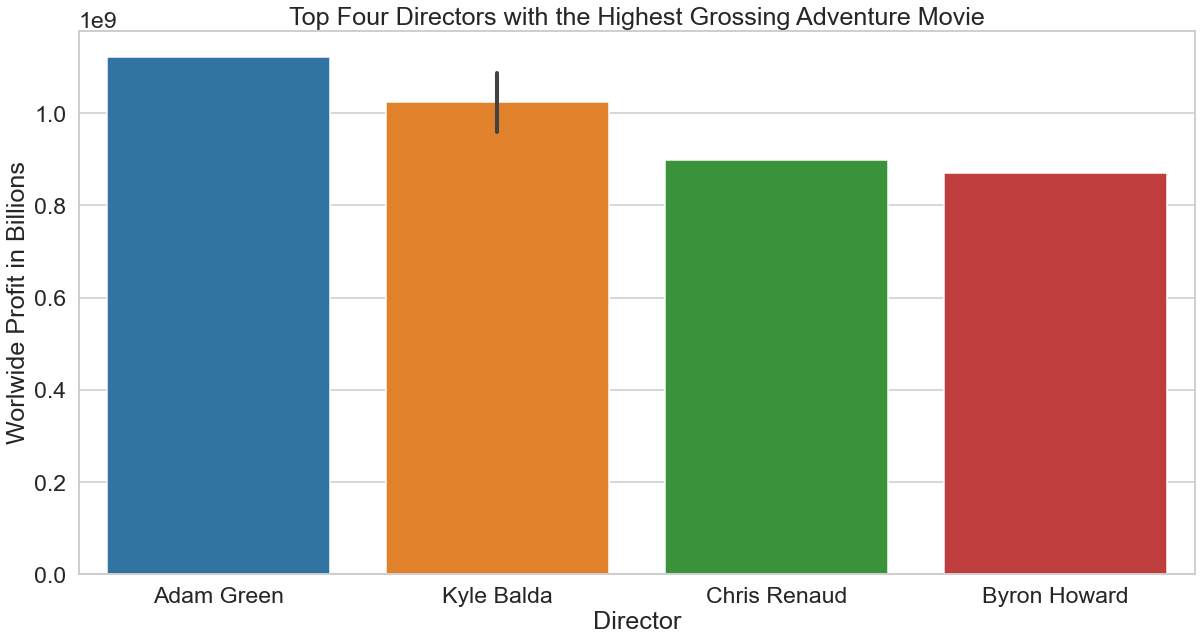

In [122]:
fig, ax = plt.subplots(figsize = (20,10))
money_graph = sns.barplot(x=money_five.primary_name, y=money_five.worldwide_profit)
money_graph.set(title="Top Four Directors with the Highest Grossing Adventure Movie", xlabel="Director", ylabel="Worlwide Profit in Billions");
# plt.savefig('Top Four Directors with Highest Grossing Adventure Movie.png', dpi=300)

<hr><font color="green"><h1>Rotten Tomatoes analysis by Josh Hill</h1></font>

# **First steps**

## Questions:

What data in rotten_tomatoes_movies data is useful for a successful business?<br>
Does the production company have any effect on the audiece rating?<br>

In [123]:
#What is in this SQL table
df_rotten_movies = pd.read_sql('''
SELECT *
FROM rotten_tomatoes_movies
''', conn)

In [124]:
#The sql information I want to clean and review, based on citation 1 (https://phys.org/news/2017-05-movies-highly-idiosyncraticand-odds-critics.html)
r_movies_info = pd.read_sql('''
SELECT movie_title as title, production_company, audience_status, audience_rating, audience_count
FROM rotten_tomatoes_movies
''', conn)

In [125]:
r_movies_info_c = r_movies_info.dropna()

In [126]:
#Comparing how much data was dropped and reduced during stage one cleaning.
print(r_movies_info_c.shape)
df_rotten_movies.shape

(16832, 5)


(17712, 23)

### Rotten Tomatoe Production Company Data:

In [127]:
r_movies_info_c2 = r_movies_info_c.drop_duplicates('title').copy()
df_production = r_movies_info_c2["production_company"].str.split('/',n = 3, expand = True)
df_production.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16276 entries, 0 to 17711
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       16276 non-null  object
 1   1       310 non-null    object
 2   2       5 non-null      object
dtypes: object(3)
memory usage: 508.6+ KB


Microsoft would be working as a solo company for this first movie so I cleaned the data to reflect this choice.

In [128]:
# Making solo Production companies.
df_production_solo = df_production.loc[(~df_production[0].index.isin(df_production[1].dropna().index)) & (~df_production[0].index.isin(df_production[2].dropna().index)), [0]]

In [129]:
# finding all the solo production company ratings
df_production_solo = df_production.loc[(~df_production[0].index.isin(df_production[1].dropna().index)) & (~df_production[0].index.isin(df_production[2].dropna().index)), [0]]
pc_names = df_production_solo[0].unique().tolist()
r_solopc = r_movies_info_c.loc[r_movies_info_c["production_company"].isin(pc_names)]
r_solopc

,title,production_company,audience_status,audience_rating,audience_count
0,Percy Jackson & the Olympians: The Lightning T...,20th Century Fox,Spilled,53.0,254421.0
1,Please Give,Sony Pictures Classics,Upright,64.0,11574.0
2,10,Waner Bros.,Spilled,53.0,14684.0
3,12 Angry Men (Twelve Angry Men),Criterion Collection,Upright,97.0,105386.0
4,"20,000 Leagues Under The Sea",Disney,Upright,74.0,68918.0
...,...,...,...,...,...
17707,Zoot Suit,MCA Universal Home Video,Upright,74.0,1195.0
17708,Zootopia,Walt Disney Animation Studios,Upright,92.0,101511.0
17709,Zorba the Greek,Fox,Upright,86.0,7146.0
17710,Zulu,Paramount Pictures,Upright,91.0,30193.0


In [130]:
r_solopc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16459 entries, 0 to 17711
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               16459 non-null  object 
 1   production_company  16459 non-null  object 
 2   audience_status     16459 non-null  object 
 3   audience_rating     16459 non-null  float64
 4   audience_count      16459 non-null  float64
dtypes: float64(2), object(3)
memory usage: 771.5+ KB


In [131]:
#Changing a duplicated title that was viewiable.
r_solopc.loc[3, ('title')] = "Twelve Angry Men"
r_solopc.head(15)

C:\Users\Catherine\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,title,production_company,audience_status,audience_rating,audience_count
0,Percy Jackson & the Olympians: The Lightning T...,20th Century Fox,Spilled,53.0,254421.0
1,Please Give,Sony Pictures Classics,Upright,64.0,11574.0
2,10,Waner Bros.,Spilled,53.0,14684.0
3,Twelve Angry Men,Criterion Collection,Upright,97.0,105386.0
4,"20,000 Leagues Under The Sea",Disney,Upright,74.0,68918.0
5,"10,000 B.C.",Warner Bros. Pictures,Spilled,37.0,411140.0
6,The 39 Steps,Gaumont British Distributors,Upright,86.0,23890.0
7,3:10 to Yuma,Columbia Pictures,Upright,79.0,9243.0
8,Charly (A Heartbeat Away),Excel Entertainment,Upright,87.0,4819.0
9,Abraham Lincoln,United Artists,Spilled,40.0,457.0


In [132]:
#Clean Movie Titles
r_solopc["title"] = r_solopc["title"].str.lower().str.replace('[^a-zA-Z0-9]', '_').copy()

<ipython-input-132-5eb12ffdb689>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  r_solopc["title"] = r_solopc["title"].str.lower().str.replace('[^a-zA-Z0-9]', '_').copy()
<ipython-input-132-5eb12ffdb689>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_solopc["title"] = r_solopc["title"].str.lower().str.replace('[^a-zA-Z0-9]', '_').copy()


In [133]:
#Confirming it changed all the Titles.
r_solopc

,title,production_company,audience_status,audience_rating,audience_count
0,percy_jackson___the_olympians__the_lightning_t...,20th Century Fox,Spilled,53.0,254421.0
1,please_give,Sony Pictures Classics,Upright,64.0,11574.0
2,10,Waner Bros.,Spilled,53.0,14684.0
3,twelve_angry_men,Criterion Collection,Upright,97.0,105386.0
4,20_000_leagues_under_the_sea,Disney,Upright,74.0,68918.0
...,...,...,...,...,...
17707,zoot_suit,MCA Universal Home Video,Upright,74.0,1195.0
17708,zootopia,Walt Disney Animation Studios,Upright,92.0,101511.0
17709,zorba_the_greek,Fox,Upright,86.0,7146.0
17710,zulu,Paramount Pictures,Upright,91.0,30193.0


## Pulling Budget information from Jerry's code.

### Attempting to use merging code to make budget graphs from my Rotten Tomatoes data

Importing Jerry's code

In [134]:
#renamed Jerry's dataframe for total budgets to work with
budget_main = df_main

In [135]:
# budget_main.drop(columns='Unnamed: 0', inplace=True)

In [136]:
#Filtering the titles to ensure the inner merge would find similar titles
budget_main["title"] = budget_main["title"].str.lower().str.replace('[^a-zA-Z0-9]', '_').copy()
clean_budget_main = budget_main.drop_duplicates("title")

<ipython-input-136-dcc8b869119c>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  budget_main["title"] = budget_main["title"].str.lower().str.replace('[^a-zA-Z0-9]', '_').copy()


Importing my previous work into this folder for merging

In [137]:
#Workable dataframe
clean_title = r_solopc
clean_title

,title,production_company,audience_status,audience_rating,audience_count
0,percy_jackson___the_olympians__the_lightning_t...,20th Century Fox,Spilled,53.0,254421.0
1,please_give,Sony Pictures Classics,Upright,64.0,11574.0
2,10,Waner Bros.,Spilled,53.0,14684.0
3,twelve_angry_men,Criterion Collection,Upright,97.0,105386.0
4,20_000_leagues_under_the_sea,Disney,Upright,74.0,68918.0
...,...,...,...,...,...
17707,zoot_suit,MCA Universal Home Video,Upright,74.0,1195.0
17708,zootopia,Walt Disney Animation Studios,Upright,92.0,101511.0
17709,zorba_the_greek,Fox,Upright,86.0,7146.0
17710,zulu,Paramount Pictures,Upright,91.0,30193.0


In [138]:
#Merging the two on common titles
rotten_budget_df = clean_budget_main.merge(clean_title, on=["title"], how="inner").copy()

In [139]:
rotten_budget_df

,popularity,title,vote_average,vote_count,vote_total,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns,production_company,audience_status,audience_rating,audience_count
0,28.515,iron_man_2,6.8,12368,84102.4,124.0,Action,170000000,621156389,451156389,2010-05-07,365.386111,Paramount Studios,Upright,71.0,480879.0
1,27.920,inception,8.3,22186,184143.8,148.0,Action,160000000,835524642,675524642,2010-07-16,522.202901,Warner Bros. Pictures,Upright,91.0,571078.0
2,26.691,percy_jackson___the_olympians__the_lightning_t...,6.1,4229,25796.9,118.0,Adventure,95000000,223050874,128050874,2010-02-11,234.790394,20th Century Fox,Spilled,53.0,254421.0
3,26.526,avatar,7.4,18676,138202.4,93.0,Horror,425000000,2776345279,2351345279,2009-12-18,653.257713,20th Century Fox,Upright,82.0,1382566.0
4,24.445,toy_story_3,7.7,8340,64218.0,103.0,Adventure,200000000,1068879522,868879522,2010-06-17,534.439761,Walt Disney Pictures,Upright,89.0,607537.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,1.836,bad_company,10.0,1,10.0,87.0,Thriller,70000000,69157016,-842984,2018-08-14,98.795737,Buena Vista Pictures,Spilled,31.0,5713.0
1532,1.836,bad_company,10.0,1,10.0,87.0,Thriller,70000000,69157016,-842984,2018-08-14,98.795737,Touchstone Pictures,Spilled,35.0,56694.0
1533,1.400,molly,5.8,5,29.0,91.0,Action,21000000,17396,-20982604,2018-09-25,0.082838,MGM Home Entertainment,Spilled,53.0,2101.0
1534,0.840,the_box,8.0,1,8.0,89.0,Drama,25000000,34356760,9356760,2018-03-04,137.427040,Warner Bros. Pictures,Spilled,24.0,359098.0


In [140]:
# Dropping repeat Titles
clean_unique_titles = rotten_budget_df.drop_duplicates("title")
clean_unique_titles

,popularity,title,vote_average,vote_count,vote_total,runtime_minutes,genre,production_budget,worldwide_gross,worldwide_profit,release_date,percent_returns,production_company,audience_status,audience_rating,audience_count
0,28.515,iron_man_2,6.8,12368,84102.4,124.0,Action,170000000,621156389,451156389,2010-05-07,365.386111,Paramount Studios,Upright,71.0,480879.0
1,27.920,inception,8.3,22186,184143.8,148.0,Action,160000000,835524642,675524642,2010-07-16,522.202901,Warner Bros. Pictures,Upright,91.0,571078.0
2,26.691,percy_jackson___the_olympians__the_lightning_t...,6.1,4229,25796.9,118.0,Adventure,95000000,223050874,128050874,2010-02-11,234.790394,20th Century Fox,Spilled,53.0,254421.0
3,26.526,avatar,7.4,18676,138202.4,93.0,Horror,425000000,2776345279,2351345279,2009-12-18,653.257713,20th Century Fox,Upright,82.0,1382566.0
4,24.445,toy_story_3,7.7,8340,64218.0,103.0,Adventure,200000000,1068879522,868879522,2010-06-17,534.439761,Walt Disney Pictures,Upright,89.0,607537.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,2.962,frenzy,3.9,9,35.1,90.0,Thriller,3500000,12600000,9100000,2018-08-15,360.000000,Universal Pictures,Upright,77.0,12623.0
1530,1.836,bad_company,10.0,1,10.0,87.0,Thriller,70000000,69157016,-842984,2018-08-14,98.795737,Paramount Pictures,Upright,71.0,2298.0
1533,1.400,molly,5.8,5,29.0,91.0,Action,21000000,17396,-20982604,2018-09-25,0.082838,MGM Home Entertainment,Spilled,53.0,2101.0
1534,0.840,the_box,8.0,1,8.0,89.0,Drama,25000000,34356760,9356760,2018-03-04,137.427040,Warner Bros. Pictures,Spilled,24.0,359098.0


In [141]:
#Break down of information that was not neccesary to my questions.
production_company = clean_unique_titles.drop(columns=["vote_average", "vote_count","vote_total","popularity","runtime_minutes","release_date", "audience_status","audience_rating","audience_count"]).copy()
production_company

,title,genre,production_budget,worldwide_gross,worldwide_profit,percent_returns,production_company
0,iron_man_2,Action,170000000,621156389,451156389,365.386111,Paramount Studios
1,inception,Action,160000000,835524642,675524642,522.202901,Warner Bros. Pictures
2,percy_jackson___the_olympians__the_lightning_t...,Adventure,95000000,223050874,128050874,234.790394,20th Century Fox
3,avatar,Horror,425000000,2776345279,2351345279,653.257713,20th Century Fox
4,toy_story_3,Adventure,200000000,1068879522,868879522,534.439761,Walt Disney Pictures
...,...,...,...,...,...,...,...
1529,frenzy,Thriller,3500000,12600000,9100000,360.000000,Universal Pictures
1530,bad_company,Thriller,70000000,69157016,-842984,98.795737,Paramount Pictures
1533,molly,Action,21000000,17396,-20982604,0.082838,MGM Home Entertainment
1534,the_box,Drama,25000000,34356760,9356760,137.427040,Warner Bros. Pictures


In [142]:
# Comparing the lost data, looks good.
clean_unique_titles.shape

(1391, 16)

In [143]:
#Cleaning Solo Production Companies to be countable
production_company["production_company"] = production_company["production_company"].str.lower().str.replace('[^a-zA-Z0-9]', '_').copy()
# merging different Production Companies into a single respective title
pc = production_company.copy()
# {'a': {'b': np.nan}}
pc.replace({"production_company" : {"paramount_studios": 'paramount','paramount_pictures':'paramount','paramount_home_video':'paramount','paramount_classics':'paramount', 
                                    'warner_bros__pictures':'warner_bros','warner_home_video':'warner_bros','warner_brothers_pictures':'warner_bros','warner_bros_':'warner_bros','warner_bros__animation':'warner_bros','warner_bros_pictures':'warner_bros',
                                    '20th_century_fox':'fox','fox_searchlight':'fox','fox_searchlight_pictures':'fox','twentieth_century_fox':'fox','twentieth_century_fox':'fox','twentieth_century_fox_home_entertainment':'fox','20th_century_fox_film_corporation':'fox','fox_searchlight_pictures__film4_and_waypoint':'fox',
                                    'walt_disney_pictures':'disney', 'walt_disney_studios':'disney', 'walt_disney_productions':'disney','walt_disney_animation_studios':'disney','marvel_studios':'disney',
                                    'lionsgate_films':'lionsgate', 'lions_gate_films':'lionsgate','lionsgate_fi_lms':'lionsgate','lionsgate_entertainment':'lionsgate','lionsgate_pictures':'lionsgate','lions_gate_releasing':'lionsgate','lionsgate_premiere':'lionsgate','lionsgate_and_cbs_films':'lionsgate', 'lionsgate_and_roadside_attractions':'lionsgate',
                                    'sony_pictures':'sony', 'sony_pictures_classics':'sony','sony_classics':'sony','sony_pictures_columbia':'sony','sony_pictures_home_entertainment':'sony','sony_screen_gems':'sony','sony_pictures_entertainment':'sony', 'sony_films':'sony', 'sony_pictures_animation':'sony',
                                    'mgm_home_entertainment':'mgm', 'mgm_pictures':'mgm','amazon_studios_and_roadside_attractions':'amazon_studios','paladin_films':'paladin','the_weinstein_company':'weinstein_company','the_weinstein_co_':'weinstein_company','ifc_midnight':'ifc','ifc_films':'ifc',
                                    'dreamworks_skg':'dreamworks', 'dreamworks_pictures':'dreamworks','dreamworks_animation':'dreamworks','dreamworks_studios':'dreamworks',
                                    'universal_pictures':'universal', 'universal_studios':'universal','mca_universal_home_video':'universal','universal_classics':'universal',
                                   }}, inplace=True)

<ipython-input-143-de75d3cec5b0>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  production_company["production_company"] = production_company["production_company"].str.lower().str.replace('[^a-zA-Z0-9]', '_').copy()


In [144]:
#Filter by the Adventure Genre
adventure = pc[pc['genre']==("Adventure")]
adventure.shape

(136, 7)

In [145]:
#Reseting Production Company to be graphable
adventure_graph = adventure["production_company"].str.replace("_"," ").str.title()
adventure_graph

2                           Fox
4                        Disney
6                    Film Chest
11                       Disney
12         Summit Entertainment
                 ...           
1507         Annapurna Pictures
1513                  Paramount
1517                     Disney
1519               Affirm Films
1526    Fun Academy Media Group
Name: production_company, Length: 136, dtype: object

In [146]:
#Making top 5 for Graphing
top_5_adventure_pc = adventure_graph.value_counts().head()
top_5_adventure_pc

Fox            26
Disney         19
Warner Bros    15
Universal      12
Paramount      11
Name: production_company, dtype: int64

In [147]:
#Sorting production companies by those who have made 5 or more movies
df_work = adventure.groupby("production_company").count().reset_index()
companies = list(df_work.loc[df_work["title"] >= 5]["production_company"])
adventure_pc_5_Movies = adventure.loc[adventure["production_company"].isin(companies)].copy()

In [148]:
#Taking the top 50 total profits
pc_wwp = adventure_pc_5_Movies.sort_values("worldwide_profit", ascending=False).head(50).copy()
pc_wwp["Production Company"] = pc_wwp["production_company"].str.replace("_"," ").str.title()

In [149]:
#Comparing how various data from the Rotten Tomatoes Data could be used with Worldwide Profit
rotten_budget_df1 = rotten_budget_df.sort_values("worldwide_profit", ascending=False).head(50).copy()
rotten_budget_df1.describe()

,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns,audience_rating,audience_count
count,50.000000,50.000000,50.000000,50.000000,50.00000,5.000000e+01,5.000000e+01,5.000000e+01,50.000000,50.000000,5.000000e+01
mean,23.781440,6.752000,8091.180000,58751.326000,121.54000,1.776320e+08,1.112009e+09,9.343765e+08,709.371621,72.860000,2.485962e+05
std,15.431823,1.009595,5549.782922,43169.452998,25.42874,7.199050e+07,3.444679e+08,3.007763e+08,302.300022,20.148439,2.955393e+05
min,2.058000,4.300000,6.000000,25.800000,64.00000,5.500000e+07,7.866806e+08,6.669800e+08,378.231048,15.000000,3.990000e+02
25%,16.689500,6.300000,5035.000000,30891.925000,108.00000,1.350000e+08,8.818124e+08,7.389779e+08,512.745555,62.000000,4.328175e+04
50%,21.710500,6.900000,7684.000000,57505.800000,121.50000,1.750000e+08,1.025491e+09,8.445441e+08,630.476924,82.000000,1.340420e+05
75%,28.481000,7.500000,11327.500000,84677.000000,141.00000,2.000000e+08,1.229983e+09,1.058159e+09,782.275274,86.000000,3.540050e+05
max,80.773000,8.300000,22186.000000,184143.800000,169.00000,4.250000e+08,2.776345e+09,2.351345e+09,1627.246076,92.000000,1.382566e+06


In [150]:
rotten_budget_df2 = rotten_budget_df.sort_values("percent_returns", ascending=False).head(50).copy()
rotten_budget_df2.describe()

,popularity,vote_average,vote_count,vote_total,runtime_minutes,production_budget,worldwide_gross,worldwide_profit,percent_returns,audience_rating,audience_count
count,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,5.000000e+01,5.000000e+01,50.000000,50.000000,50.000000
mean,10.850420,6.228000,2244.660000,15460.896000,101.940000,6.003960e+06,1.542673e+08,1.482634e+08,5002.965215,61.300000,79662.140000
std,7.137957,1.144114,2883.397016,21496.072045,19.328957,8.005153e+06,1.646281e+08,1.569223e+08,7191.078966,20.576636,92953.642247
min,0.600000,2.000000,1.000000,2.000000,79.000000,1.000000e+05,2.769782e+06,2.669782e+06,1656.624000,22.000000,149.000000
25%,7.187000,5.525000,176.250000,1058.550000,87.000000,1.000000e+06,3.246614e+07,3.159114e+07,2140.248971,45.000000,23539.250000
50%,9.628000,6.400000,1227.500000,7355.850000,99.000000,3.000000e+06,9.497220e+07,9.097220e+07,2632.105933,66.000000,51519.500000
75%,15.948000,7.000000,3193.500000,20012.175000,110.750000,6.875000e+06,2.549007e+08,2.449007e+08,4322.568625,79.750000,95439.750000
max,29.154000,8.000000,10931.000000,79221.200000,160.000000,3.500000e+07,6.974580e+08,6.624580e+08,41656.474000,89.000000,469588.000000


# Graph time!

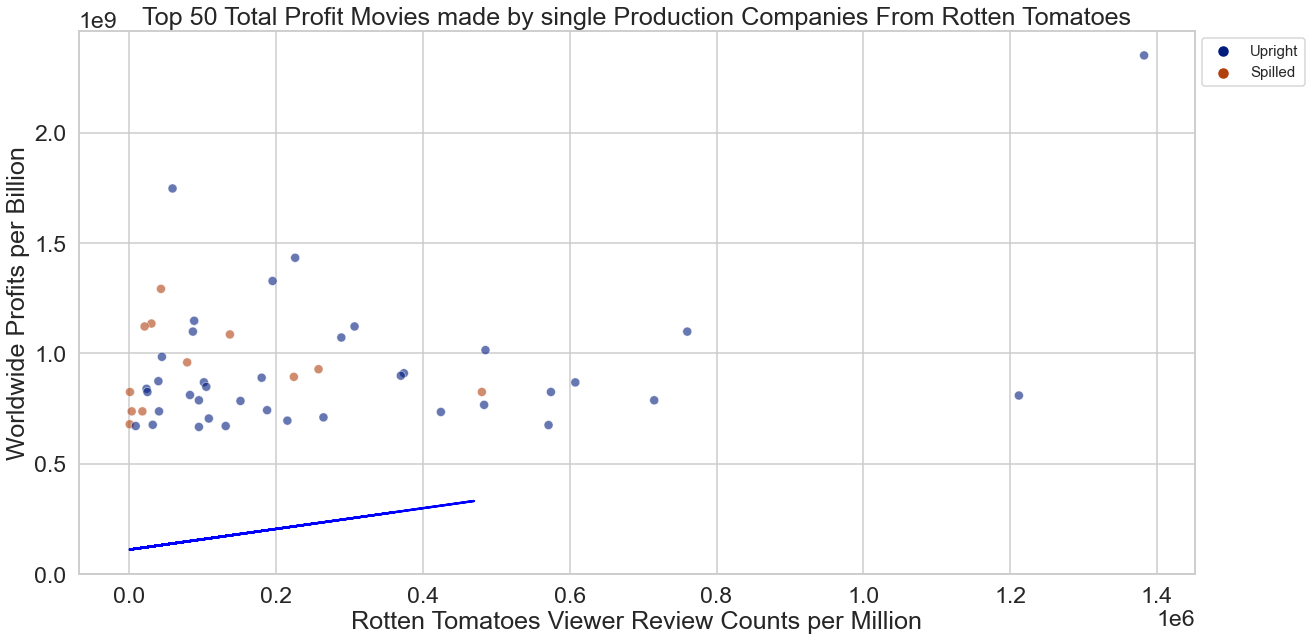

In [151]:
plt.figure(figsize=(20,10))
top_50_RT_profit_ar = sns.scatterplot(data=rotten_budget_df1, x="audience_count", y="worldwide_profit", hue="audience_status" ,palette="dark",alpha=0.6, sizes=(20, 200))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=15)
top_50_RT_profit_ar.set(title="Top 50 Total Profit Movies made by single Production Companies From Rotten Tomatoes", xlabel="Rotten Tomatoes Viewer Review Counts per Million", ylabel="Worldwide Profits per Billion")
x = rotten_budget_df2["audience_count"]
y = rotten_budget_df2["worldwide_profit"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b-");
# sns.lmplot(data = rotten_budget_df2, x =  "audience_rating", y ="worldwide_profit", legend = True, markers=".", line_kws={'color': 'red'})
# plt.savefig('Top_50_Total_Profit_Movies.png', dpi=300)

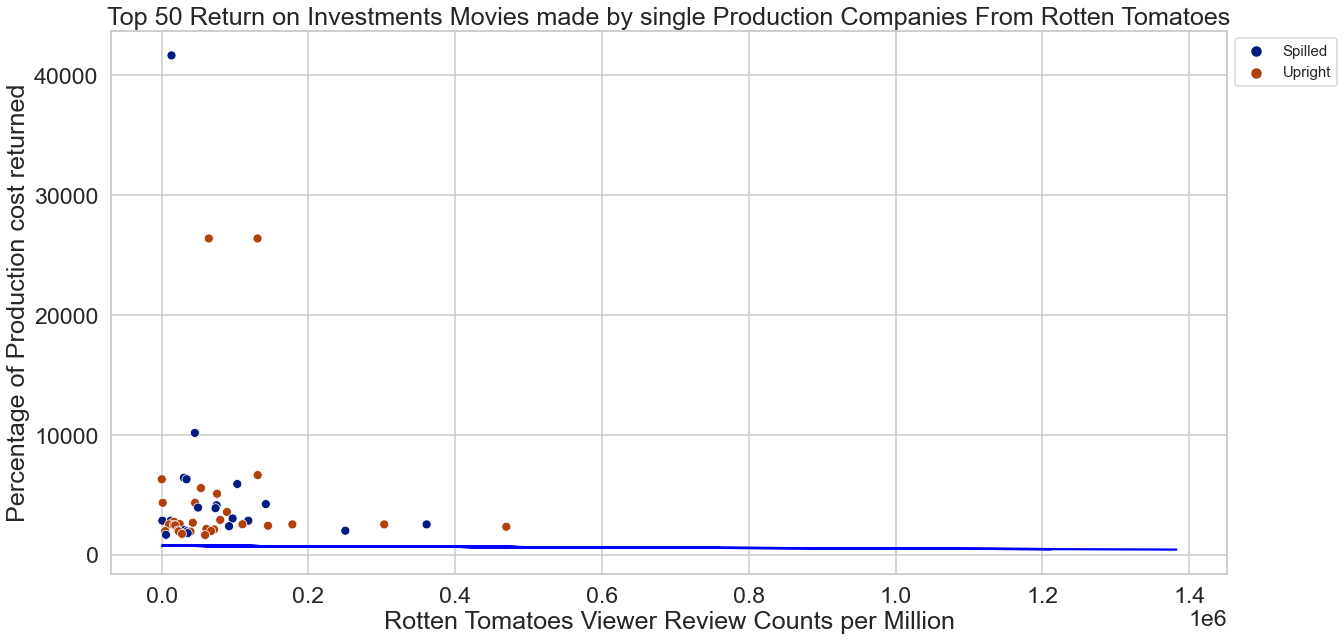

In [152]:
plt.figure(figsize=(20,10))
top_50_RT_profit_ar = sns.scatterplot(data=rotten_budget_df2, x="audience_count", y="percent_returns", hue="audience_status", palette="dark", sizes=(20, 200))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=15)
top_50_RT_profit_ar.set(title="Top 50 Return on Investments Movies made by single Production Companies From Rotten Tomatoes", xlabel="Rotten Tomatoes Viewer Review Counts per Million", ylabel="Percentage of Production cost returned")
# plt.ylim(0, 10000)
# plt.xlim(0, 400000)
x = rotten_budget_df1["audience_count"]
y = rotten_budget_df1["percent_returns"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b-");

In [153]:
rotten_budget_df.value_counts("production_company").head(10)

production_company
Warner Bros. Pictures    121
20th Century Fox         115
Universal Pictures       113
Sony Pictures             85
Paramount Pictures        79
Walt Disney Pictures      57
Focus Features            44
The Weinstein Company     31
Lionsgate Films           30
Lionsgate                 29
dtype: int64

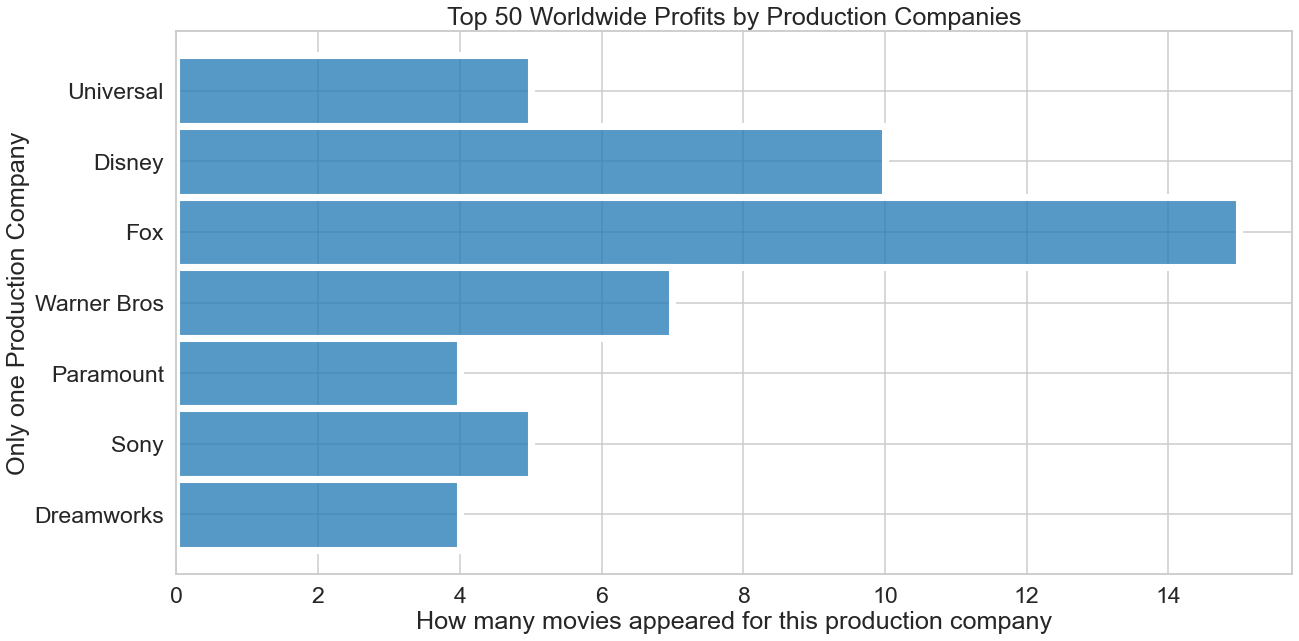

In [168]:
# Who made the top 50 highest grossing movie by Production Company
plt.figure(figsize=(20,10))
top_50_ProductionCompanies = sns.histplot(data=pc_wwp, y="Production Company")
# top_50_ProductionCompanies.legend(labels=("Rotten Tomato Approval","Rotten Tomato Disapproval"))
top_50_ProductionCompanies.set(title="Top 50 Worldwide Profits by Production Companies", xlabel="How many movies appeared for this production company", ylabel="Only one Production Company");
# plt.savefig('Top_50_Worldwide_Profit_by_Production_Company_with_RT_Rating.png', dpi=300)

In [155]:
genre_cleaned = clean_unique_titles.loc[clean_unique_titles["genre"].apply(lambda x: (x=='Musical') | (x=='Action') | (x=='Adventure') | (x=='Animation')|(x=='Sci-Fi')|(x=='Family')|(x=='Fantasy'))].copy()
genre_cleaned_wwprofit = genre_cleaned.sort_values("worldwide_profit", ascending=False).head(100).copy()

<AxesSubplot:xlabel='genre', ylabel='worldwide_profit'>

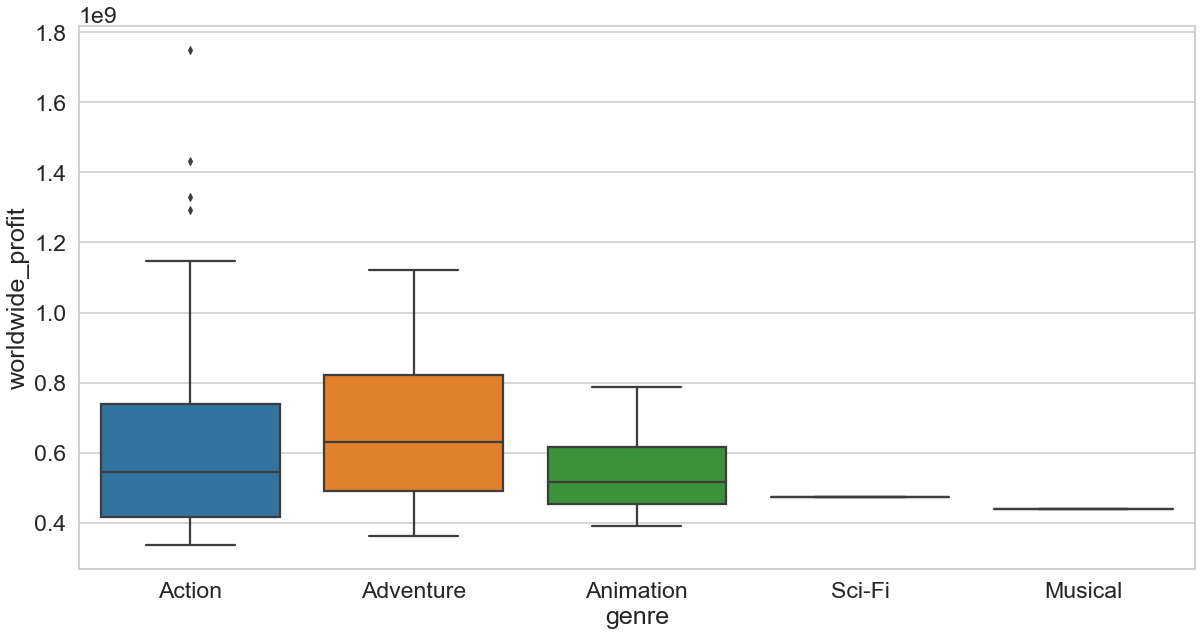

In [156]:
fig, ax = plt.subplots(figsize = (20,10))
sns.boxplot(data = genre_cleaned_wwprofit, x = "genre", y = "worldwide_profit")

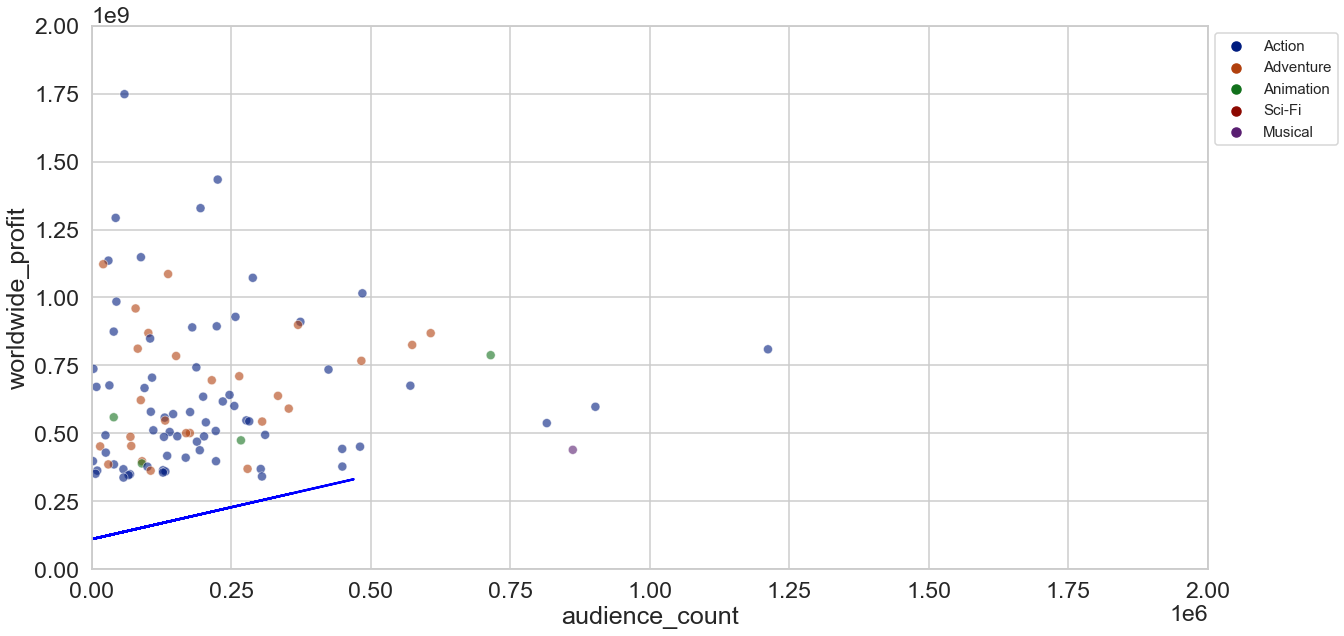

In [157]:
#RT amount of votes does have a positive relationship with profit
plt.figure(figsize=(20,10))
top_100_RT_profit_genre = sns.scatterplot(data=genre_cleaned_wwprofit, x="audience_count", y="worldwide_profit", hue="genre" ,palette="dark",alpha=0.6, sizes=(20, 200))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=15)
# top_100_RT_profit_genre.set(title="Top 50 Total Profit Movies", xlabel="Rotten Tomatoes Viewer Review Counts per Million", ylabel="Worldwide Profits per Billion")
x = rotten_budget_df2["audience_count"]
y = rotten_budget_df2["worldwide_profit"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b-")
plt.ylim(0, 2000000000)
plt.xlim(0, 2000000);

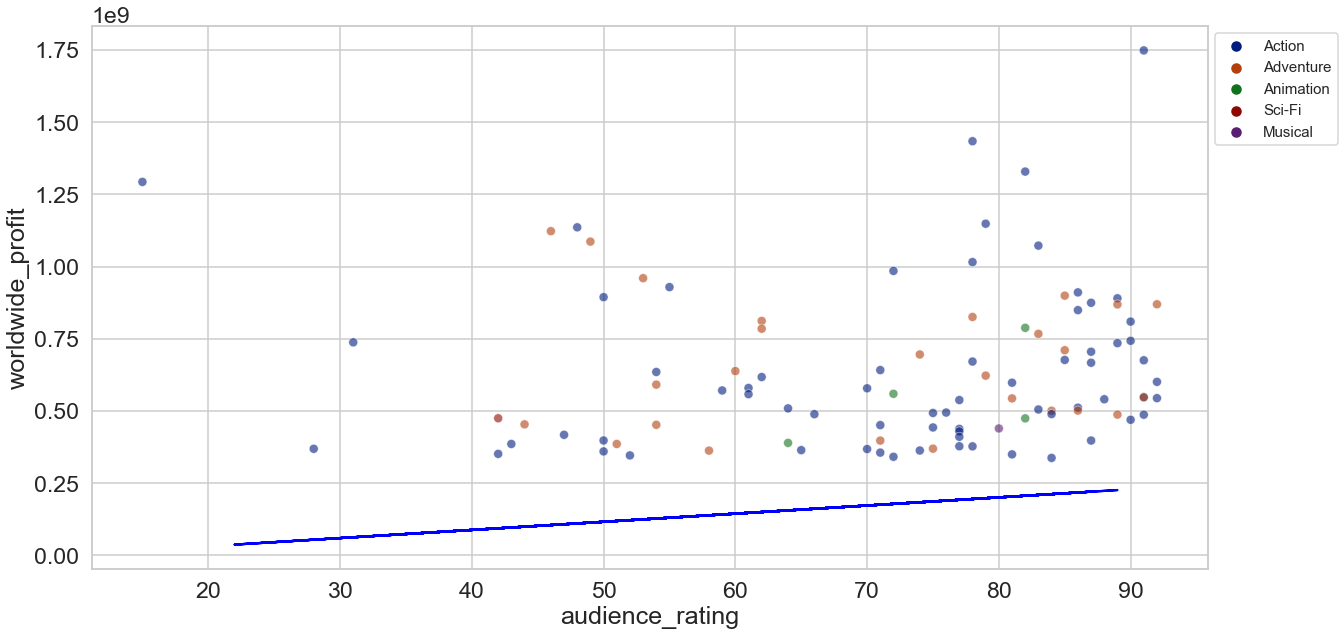

In [158]:
# Rating does not change how well the movie did
plt.figure(figsize=(20,10))
top_100_RT_profit_genre = sns.scatterplot(data=genre_cleaned_wwprofit, x="audience_rating", y="worldwide_profit", hue="genre" ,palette="dark",alpha=0.6, sizes=(20, 200))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=15)
# top_100_RT_profit_genre.set(title="Top 50 Total Profit Movies", xlabel="Rotten Tomatoes Viewer Review Counts per Million", ylabel="Worldwide Profits per Billion")
x = rotten_budget_df2["audience_rating"]
y = rotten_budget_df2["worldwide_profit"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b-");
# plt.ylim(0, 2000000000)
# plt.xlim(0, 2000000)

In [159]:
#Setting a color palette so below graphs match.
color_dictionary = {'Fox':"blue",
                    "Universal":"red",
                    "Disney":"orange",
                    "Warner Bros":"green",
                    "Paramount":"purple",
                    "Sony": "cyan",
                    "Dreamworks":"white"}

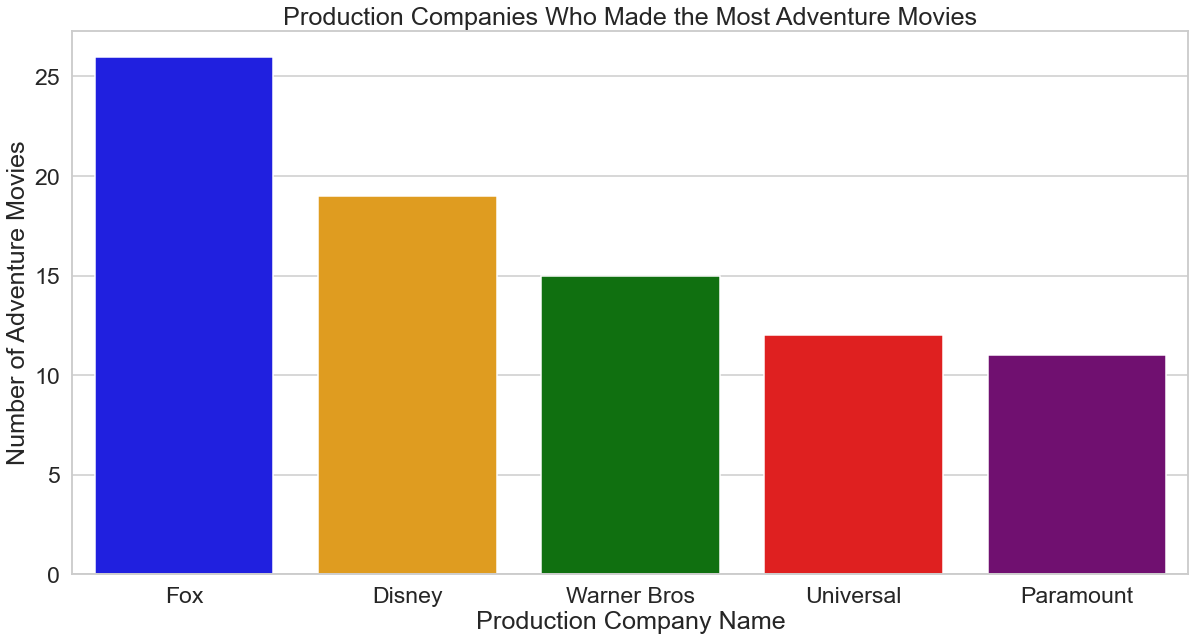

In [160]:
fig, ax = plt.subplots(figsize = (20,10))
Most_Adventure_PC = sns.barplot(x=top_5_adventure_pc.index, y=top_5_adventure_pc.values,palette=color_dictionary)
Most_Adventure_PC.set(title="Production Companies Who Made the Most Adventure Movies", xlabel="Production Company Name", ylabel="Number of Adventure Movies");
# plt.savefig('Production_Company_Most_Movies.png', dpi=300)

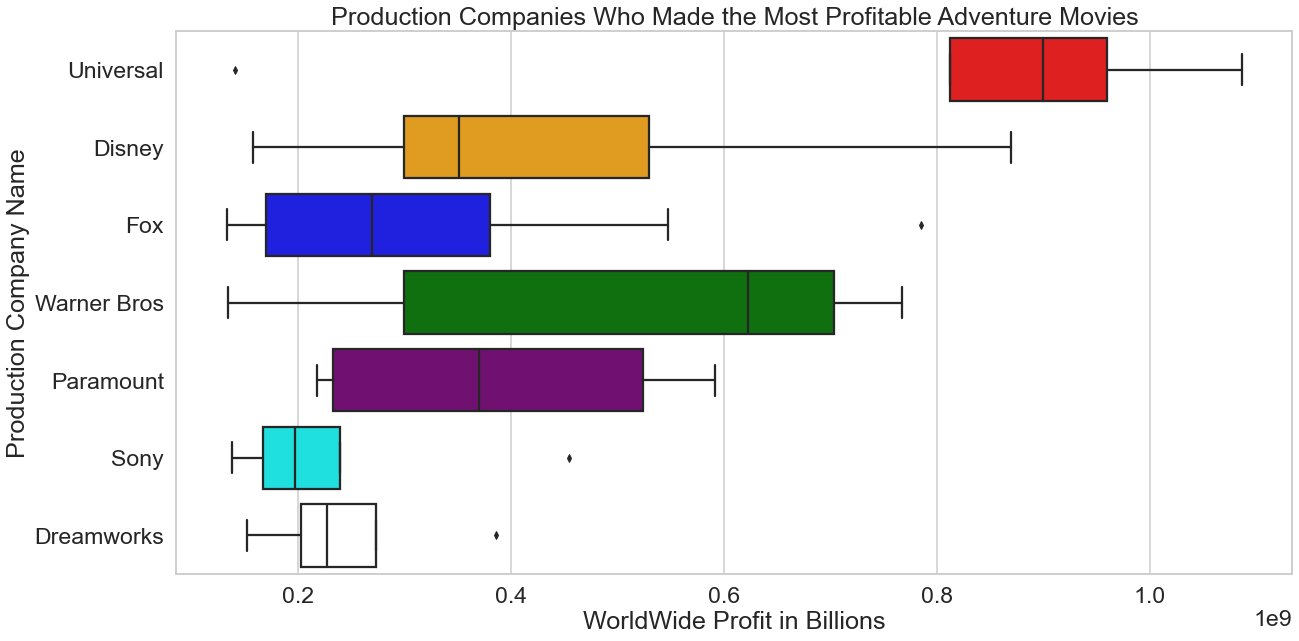

In [162]:
fig, ax = plt.subplots(figsize = (20,10))
# pc = pc_wwp["production_company"].apply(lambda x: x)
PC_Adventure_Profit=sns.boxplot(data = pc_wwp, y ="Production Company", x ="worldwide_profit", palette=color_dictionary)
PC_Adventure_Profit.set(title="Production Companies Who Made the Most Profitable Adventure Movies", xlabel="WorldWide Profit in Billions", ylabel="Production Company Name");
# plt.savefig('Production_Company_Profit.png', dpi=300)